### In Conditional GANS (CGAN), a conditional setting is applied, meaning that both the generator and discriminator are conditioned on some sort of auxiliary information (such as class labels or data) from other modalities. As a result, the ideal model can learn multi-modal mapping from inputs to outputs by being fed with different contextual information. This prevents mode-collapse, a common issue with traditional GANS.

## Step 1: Importing the packages

In [1]:
#installing older vrsion of pillow as latest version breaks PyTorch
##conda install pillow=6.2.1

In [2]:
from __future__ import print_function
#%matplotlib inline

#library which integrates code with operating system
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# used to generate random vector of data/noise as input for the generator
import random 

# helps us write user-frindly code, especially when dealing with varaibles within functions
import argparse 

import math

#main PyTorch framework and libraries we need to use
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.optim import RMSprop


 #used for most of our mathematical oprations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image


## Step 2: Getting data and defining hyperparameters

In [3]:
# Root directory for dataset
dataroot = r"C:\Users\Ray\OneDrive\Desktop\Capstone Project\GAN_images\crests\holding_pen"

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 50

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Number of classes in the training set.
n_classes = 22

# The interval between image sampling.
sample_interval = 400

## Step 3: Loading and plotting our intial data

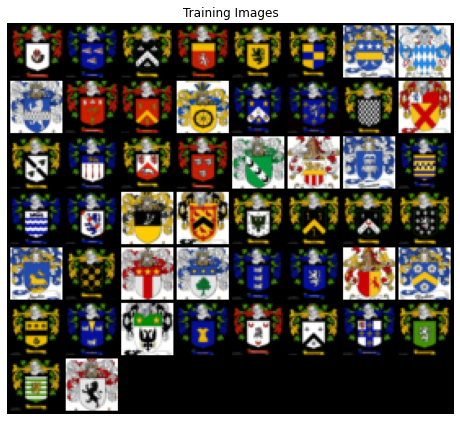

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,# the folder where the data is located
                           #reshaping the data in the form we desire
                           transform=transforms.Compose([
                               transforms.Resize(image_size),#resizing
                               transforms.CenterCrop(image_size), #cropping and centering
                               transforms.ToTensor(), #tranforming image data to tensors
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #normalising the data
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True, #shuffing images so the  genrator doesn't overfit on the sequence
                                         num_workers=workers)

# Decide which device we want to run on. Basically telling the model to run on the GPU if its available.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
#device = torch.device("cpu")

# Plot some random training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Step 4: Initialising our weights


In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Step 5: Creating Generator and Discriminator


In [6]:
image_shape = (nc, image_size, image_size)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(nz + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(image_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *image_shape)
        return img

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(image_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [8]:
# Create the generators
netG = Generator().to(device)

# Initialize weights
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (label_emb): Embedding(22, 22)
  (model): Sequential(
    (0): Linear(in_features=122, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=3072, bias=True)
    (12): Tanh()
  )
)


In [9]:
# Create the discriminators
netD = Discriminator().to(device)

# Initialize weights
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (label_embedding): Embedding(22, 22)
  (model): Sequential(
    (0): Linear(in_features=3094, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [10]:
# Initialize MSELoss function
loss = nn.MSELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
FloatTensor = torch.cuda.FloatTensor 
LongTensor = torch.cuda.LongTensor

os.makedirs("Crest_Generated_Images", exist_ok=True)
os.makedirs(dataroot, exist_ok=True)

def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, nz))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = netG(z, labels)
    save_image(gen_imgs.data, "Crest_Generated_Images/%d.png" % batches_done, nrow=n_row, normalize=True)

## Step 6: Creating Generator and Discriminator


In [12]:
# ----------
#  Training
# ----------

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizerG.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, nz))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = netG(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = netD(gen_imgs, gen_labels)
        g_loss = loss(validity, valid)

        g_loss.backward()
        optimizerG.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizerD.zero_grad()

        # Loss for real images
        validity_real = netD(real_imgs, labels)
        d_real_loss = loss(validity_real, valid)

        # Loss for fake images
        validity_fake = netD(gen_imgs.detach(), gen_labels)
        d_fake_loss = loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizerD.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)

[Epoch 0/500] [Batch 0/28] [D loss: 0.479859] [G loss: 0.959131]
[Epoch 0/500] [Batch 1/28] [D loss: 0.293550] [G loss: 0.922135]
[Epoch 0/500] [Batch 2/28] [D loss: 0.109696] [G loss: 0.895634]
[Epoch 0/500] [Batch 3/28] [D loss: 0.099422] [G loss: 0.860915]
[Epoch 0/500] [Batch 4/28] [D loss: 0.047447] [G loss: 0.837598]
[Epoch 0/500] [Batch 5/28] [D loss: 0.050636] [G loss: 0.825060]
[Epoch 0/500] [Batch 6/28] [D loss: 0.042132] [G loss: 0.803343]
[Epoch 0/500] [Batch 7/28] [D loss: 0.026861] [G loss: 0.765445]
[Epoch 0/500] [Batch 8/28] [D loss: 0.031820] [G loss: 0.745764]
[Epoch 0/500] [Batch 9/28] [D loss: 0.019011] [G loss: 0.738432]
[Epoch 0/500] [Batch 10/28] [D loss: 0.028721] [G loss: 0.731690]
[Epoch 0/500] [Batch 11/28] [D loss: 0.022884] [G loss: 0.714088]
[Epoch 0/500] [Batch 12/28] [D loss: 0.025219] [G loss: 0.703781]
[Epoch 0/500] [Batch 13/28] [D loss: 0.033228] [G loss: 0.675761]
[Epoch 0/500] [Batch 14/28] [D loss: 0.033859] [G loss: 0.675186]
[Epoch 0/500] [Batch

[Epoch 4/500] [Batch 13/28] [D loss: 0.060894] [G loss: 0.735173]
[Epoch 4/500] [Batch 14/28] [D loss: 0.035988] [G loss: 0.915418]
[Epoch 4/500] [Batch 15/28] [D loss: 0.050425] [G loss: 0.857443]
[Epoch 4/500] [Batch 16/28] [D loss: 0.041776] [G loss: 0.682672]
[Epoch 4/500] [Batch 17/28] [D loss: 0.049135] [G loss: 1.013440]
[Epoch 4/500] [Batch 18/28] [D loss: 0.064027] [G loss: 0.741986]
[Epoch 4/500] [Batch 19/28] [D loss: 0.065046] [G loss: 0.848245]
[Epoch 4/500] [Batch 20/28] [D loss: 0.059443] [G loss: 0.664914]
[Epoch 4/500] [Batch 21/28] [D loss: 0.064374] [G loss: 0.826828]
[Epoch 4/500] [Batch 22/28] [D loss: 0.049536] [G loss: 0.747228]
[Epoch 4/500] [Batch 23/28] [D loss: 0.036970] [G loss: 0.829874]
[Epoch 4/500] [Batch 24/28] [D loss: 0.050731] [G loss: 1.176915]
[Epoch 4/500] [Batch 25/28] [D loss: 0.164796] [G loss: 0.357449]
[Epoch 4/500] [Batch 26/28] [D loss: 0.243575] [G loss: 1.993954]
[Epoch 4/500] [Batch 27/28] [D loss: 0.078559] [G loss: 0.634386]
[Epoch 5/5

[Epoch 8/500] [Batch 26/28] [D loss: 0.066817] [G loss: 0.811289]
[Epoch 8/500] [Batch 27/28] [D loss: 0.061234] [G loss: 0.703521]
[Epoch 9/500] [Batch 0/28] [D loss: 0.042461] [G loss: 1.038254]
[Epoch 9/500] [Batch 1/28] [D loss: 0.054932] [G loss: 0.850293]
[Epoch 9/500] [Batch 2/28] [D loss: 0.077429] [G loss: 0.708181]
[Epoch 9/500] [Batch 3/28] [D loss: 0.059006] [G loss: 0.674121]
[Epoch 9/500] [Batch 4/28] [D loss: 0.042618] [G loss: 1.031439]
[Epoch 9/500] [Batch 5/28] [D loss: 0.044423] [G loss: 0.608536]
[Epoch 9/500] [Batch 6/28] [D loss: 0.079304] [G loss: 1.264686]
[Epoch 9/500] [Batch 7/28] [D loss: 0.055551] [G loss: 0.812545]
[Epoch 9/500] [Batch 8/28] [D loss: 0.048344] [G loss: 0.738538]
[Epoch 9/500] [Batch 9/28] [D loss: 0.037225] [G loss: 0.849847]
[Epoch 9/500] [Batch 10/28] [D loss: 0.028380] [G loss: 0.828946]
[Epoch 9/500] [Batch 11/28] [D loss: 0.054707] [G loss: 0.809917]
[Epoch 9/500] [Batch 12/28] [D loss: 0.039035] [G loss: 0.678495]
[Epoch 9/500] [Batch

[Epoch 13/500] [Batch 10/28] [D loss: 0.083435] [G loss: 0.760865]
[Epoch 13/500] [Batch 11/28] [D loss: 0.071547] [G loss: 0.511005]
[Epoch 13/500] [Batch 12/28] [D loss: 0.129127] [G loss: 1.183052]
[Epoch 13/500] [Batch 13/28] [D loss: 0.095517] [G loss: 0.649176]
[Epoch 13/500] [Batch 14/28] [D loss: 0.066853] [G loss: 0.596417]
[Epoch 13/500] [Batch 15/28] [D loss: 0.066162] [G loss: 1.004476]
[Epoch 13/500] [Batch 16/28] [D loss: 0.047423] [G loss: 0.748278]
[Epoch 13/500] [Batch 17/28] [D loss: 0.048259] [G loss: 0.731121]
[Epoch 13/500] [Batch 18/28] [D loss: 0.068174] [G loss: 0.960045]
[Epoch 13/500] [Batch 19/28] [D loss: 0.051269] [G loss: 0.624724]
[Epoch 13/500] [Batch 20/28] [D loss: 0.047060] [G loss: 0.982780]
[Epoch 13/500] [Batch 21/28] [D loss: 0.036561] [G loss: 0.720560]
[Epoch 13/500] [Batch 22/28] [D loss: 0.078066] [G loss: 0.785242]
[Epoch 13/500] [Batch 23/28] [D loss: 0.048771] [G loss: 0.715393]
[Epoch 13/500] [Batch 24/28] [D loss: 0.069868] [G loss: 1.133

[Epoch 17/500] [Batch 21/28] [D loss: 0.063494] [G loss: 1.107265]
[Epoch 17/500] [Batch 22/28] [D loss: 0.076073] [G loss: 0.667565]
[Epoch 17/500] [Batch 23/28] [D loss: 0.065887] [G loss: 0.666667]
[Epoch 17/500] [Batch 24/28] [D loss: 0.038661] [G loss: 0.928260]
[Epoch 17/500] [Batch 25/28] [D loss: 0.057261] [G loss: 0.916384]
[Epoch 17/500] [Batch 26/28] [D loss: 0.054494] [G loss: 0.682270]
[Epoch 17/500] [Batch 27/28] [D loss: 0.045588] [G loss: 0.983888]
[Epoch 18/500] [Batch 0/28] [D loss: 0.075901] [G loss: 0.580581]
[Epoch 18/500] [Batch 1/28] [D loss: 0.043772] [G loss: 1.122377]
[Epoch 18/500] [Batch 2/28] [D loss: 0.042567] [G loss: 0.869638]
[Epoch 18/500] [Batch 3/28] [D loss: 0.076239] [G loss: 0.664736]
[Epoch 18/500] [Batch 4/28] [D loss: 0.039490] [G loss: 0.938433]
[Epoch 18/500] [Batch 5/28] [D loss: 0.071566] [G loss: 0.903032]
[Epoch 18/500] [Batch 6/28] [D loss: 0.077386] [G loss: 0.504626]
[Epoch 18/500] [Batch 7/28] [D loss: 0.052886] [G loss: 1.325606]
[Ep

[Epoch 22/500] [Batch 4/28] [D loss: 0.051811] [G loss: 0.656236]
[Epoch 22/500] [Batch 5/28] [D loss: 0.042090] [G loss: 0.797871]
[Epoch 22/500] [Batch 6/28] [D loss: 0.045063] [G loss: 1.051399]
[Epoch 22/500] [Batch 7/28] [D loss: 0.049837] [G loss: 0.753787]
[Epoch 22/500] [Batch 8/28] [D loss: 0.033679] [G loss: 0.721069]
[Epoch 22/500] [Batch 9/28] [D loss: 0.056162] [G loss: 1.010299]
[Epoch 22/500] [Batch 10/28] [D loss: 0.059220] [G loss: 0.663421]
[Epoch 22/500] [Batch 11/28] [D loss: 0.039171] [G loss: 0.782043]
[Epoch 22/500] [Batch 12/28] [D loss: 0.056496] [G loss: 1.039776]
[Epoch 22/500] [Batch 13/28] [D loss: 0.059715] [G loss: 0.623663]
[Epoch 22/500] [Batch 14/28] [D loss: 0.035878] [G loss: 0.987564]
[Epoch 22/500] [Batch 15/28] [D loss: 0.050305] [G loss: 0.971276]
[Epoch 22/500] [Batch 16/28] [D loss: 0.086681] [G loss: 0.505977]
[Epoch 22/500] [Batch 17/28] [D loss: 0.096544] [G loss: 1.326115]
[Epoch 22/500] [Batch 18/28] [D loss: 0.034537] [G loss: 0.779185]
[

[Epoch 26/500] [Batch 15/28] [D loss: 0.034643] [G loss: 0.891165]
[Epoch 26/500] [Batch 16/28] [D loss: 0.051572] [G loss: 0.932396]
[Epoch 26/500] [Batch 17/28] [D loss: 0.055806] [G loss: 0.591142]
[Epoch 26/500] [Batch 18/28] [D loss: 0.025277] [G loss: 0.885515]
[Epoch 26/500] [Batch 19/28] [D loss: 0.030602] [G loss: 0.815656]
[Epoch 26/500] [Batch 20/28] [D loss: 0.034850] [G loss: 0.796170]
[Epoch 26/500] [Batch 21/28] [D loss: 0.031875] [G loss: 0.841072]
[Epoch 26/500] [Batch 22/28] [D loss: 0.037252] [G loss: 0.739056]
[Epoch 26/500] [Batch 23/28] [D loss: 0.040808] [G loss: 0.808552]
[Epoch 26/500] [Batch 24/28] [D loss: 0.054714] [G loss: 0.683173]
[Epoch 26/500] [Batch 25/28] [D loss: 0.050290] [G loss: 1.201251]
[Epoch 26/500] [Batch 26/28] [D loss: 0.041853] [G loss: 0.768619]
[Epoch 26/500] [Batch 27/28] [D loss: 0.035888] [G loss: 0.694020]
[Epoch 27/500] [Batch 0/28] [D loss: 0.046876] [G loss: 0.694077]
[Epoch 27/500] [Batch 1/28] [D loss: 0.078166] [G loss: 1.02273

[Epoch 30/500] [Batch 26/28] [D loss: 0.134442] [G loss: 0.697713]
[Epoch 30/500] [Batch 27/28] [D loss: 0.150119] [G loss: 1.081859]
[Epoch 31/500] [Batch 0/28] [D loss: 0.094979] [G loss: 1.011327]
[Epoch 31/500] [Batch 1/28] [D loss: 0.047736] [G loss: 0.685484]
[Epoch 31/500] [Batch 2/28] [D loss: 0.065567] [G loss: 0.629144]
[Epoch 31/500] [Batch 3/28] [D loss: 0.077383] [G loss: 0.653637]
[Epoch 31/500] [Batch 4/28] [D loss: 0.061760] [G loss: 0.666706]
[Epoch 31/500] [Batch 5/28] [D loss: 0.053470] [G loss: 0.634483]
[Epoch 31/500] [Batch 6/28] [D loss: 0.057202] [G loss: 0.779315]
[Epoch 31/500] [Batch 7/28] [D loss: 0.047717] [G loss: 0.808841]
[Epoch 31/500] [Batch 8/28] [D loss: 0.054653] [G loss: 0.690244]
[Epoch 31/500] [Batch 9/28] [D loss: 0.098480] [G loss: 0.632412]
[Epoch 31/500] [Batch 10/28] [D loss: 0.213109] [G loss: 0.826878]
[Epoch 31/500] [Batch 11/28] [D loss: 0.162489] [G loss: 0.704177]
[Epoch 31/500] [Batch 12/28] [D loss: 0.076759] [G loss: 0.679384]
[Epoc

[Epoch 35/500] [Batch 10/28] [D loss: 0.054542] [G loss: 0.681559]
[Epoch 35/500] [Batch 11/28] [D loss: 0.038665] [G loss: 0.718432]
[Epoch 35/500] [Batch 12/28] [D loss: 0.054030] [G loss: 0.696892]
[Epoch 35/500] [Batch 13/28] [D loss: 0.053626] [G loss: 0.637860]
[Epoch 35/500] [Batch 14/28] [D loss: 0.081075] [G loss: 0.675731]
[Epoch 35/500] [Batch 15/28] [D loss: 0.122616] [G loss: 0.539353]
[Epoch 35/500] [Batch 16/28] [D loss: 0.262362] [G loss: 0.881220]
[Epoch 35/500] [Batch 17/28] [D loss: 0.309299] [G loss: 0.536894]
[Epoch 35/500] [Batch 18/28] [D loss: 0.145567] [G loss: 0.568717]
[Epoch 35/500] [Batch 19/28] [D loss: 0.187282] [G loss: 0.691048]
[Epoch 35/500] [Batch 20/28] [D loss: 0.149747] [G loss: 0.570915]
[Epoch 35/500] [Batch 21/28] [D loss: 0.149345] [G loss: 0.636728]
[Epoch 35/500] [Batch 22/28] [D loss: 0.135025] [G loss: 0.488070]
[Epoch 35/500] [Batch 23/28] [D loss: 0.095254] [G loss: 0.541904]
[Epoch 35/500] [Batch 24/28] [D loss: 0.083086] [G loss: 0.699

[Epoch 39/500] [Batch 21/28] [D loss: 0.117932] [G loss: 0.522591]
[Epoch 39/500] [Batch 22/28] [D loss: 0.106298] [G loss: 0.581049]
[Epoch 39/500] [Batch 23/28] [D loss: 0.094115] [G loss: 0.536262]
[Epoch 39/500] [Batch 24/28] [D loss: 0.070754] [G loss: 0.609408]
[Epoch 39/500] [Batch 25/28] [D loss: 0.078324] [G loss: 0.571916]
[Epoch 39/500] [Batch 26/28] [D loss: 0.063875] [G loss: 0.627278]
[Epoch 39/500] [Batch 27/28] [D loss: 0.071125] [G loss: 0.702874]
[Epoch 40/500] [Batch 0/28] [D loss: 0.077184] [G loss: 0.546939]
[Epoch 40/500] [Batch 1/28] [D loss: 0.077584] [G loss: 0.633130]
[Epoch 40/500] [Batch 2/28] [D loss: 0.064216] [G loss: 0.697677]
[Epoch 40/500] [Batch 3/28] [D loss: 0.165358] [G loss: 0.392098]
[Epoch 40/500] [Batch 4/28] [D loss: 0.934065] [G loss: 1.532610]
[Epoch 40/500] [Batch 5/28] [D loss: 0.322422] [G loss: 0.969527]
[Epoch 40/500] [Batch 6/28] [D loss: 0.192327] [G loss: 0.677307]
[Epoch 40/500] [Batch 7/28] [D loss: 0.135673] [G loss: 0.569667]
[Ep

[Epoch 44/500] [Batch 5/28] [D loss: 0.171825] [G loss: 0.774804]
[Epoch 44/500] [Batch 6/28] [D loss: 0.182034] [G loss: 0.674941]
[Epoch 44/500] [Batch 7/28] [D loss: 0.183035] [G loss: 0.436935]
[Epoch 44/500] [Batch 8/28] [D loss: 0.135967] [G loss: 0.405637]
[Epoch 44/500] [Batch 9/28] [D loss: 0.134942] [G loss: 0.472082]
[Epoch 44/500] [Batch 10/28] [D loss: 0.137402] [G loss: 0.536614]
[Epoch 44/500] [Batch 11/28] [D loss: 0.145559] [G loss: 0.530225]
[Epoch 44/500] [Batch 12/28] [D loss: 0.118899] [G loss: 0.557401]
[Epoch 44/500] [Batch 13/28] [D loss: 0.093229] [G loss: 0.516425]
[Epoch 44/500] [Batch 14/28] [D loss: 0.088639] [G loss: 0.586175]
[Epoch 44/500] [Batch 15/28] [D loss: 0.094994] [G loss: 0.583070]
[Epoch 44/500] [Batch 16/28] [D loss: 0.096265] [G loss: 0.734869]
[Epoch 44/500] [Batch 17/28] [D loss: 0.137958] [G loss: 0.379395]
[Epoch 44/500] [Batch 18/28] [D loss: 0.150584] [G loss: 0.766117]
[Epoch 44/500] [Batch 19/28] [D loss: 0.222619] [G loss: 0.358148]


[Epoch 48/500] [Batch 16/28] [D loss: 0.146314] [G loss: 0.801006]
[Epoch 48/500] [Batch 17/28] [D loss: 0.185737] [G loss: 0.355785]
[Epoch 48/500] [Batch 18/28] [D loss: 0.290827] [G loss: 1.047871]
[Epoch 48/500] [Batch 19/28] [D loss: 0.168448] [G loss: 0.411348]
[Epoch 48/500] [Batch 20/28] [D loss: 0.129590] [G loss: 0.576361]
[Epoch 48/500] [Batch 21/28] [D loss: 0.128382] [G loss: 0.610167]
[Epoch 48/500] [Batch 22/28] [D loss: 0.109968] [G loss: 0.499588]
[Epoch 48/500] [Batch 23/28] [D loss: 0.142953] [G loss: 0.453767]
[Epoch 48/500] [Batch 24/28] [D loss: 0.131633] [G loss: 0.749604]
[Epoch 48/500] [Batch 25/28] [D loss: 0.130916] [G loss: 0.383376]
[Epoch 48/500] [Batch 26/28] [D loss: 0.112668] [G loss: 0.733035]
[Epoch 48/500] [Batch 27/28] [D loss: 0.095456] [G loss: 0.562850]
[Epoch 49/500] [Batch 0/28] [D loss: 0.129811] [G loss: 0.484408]
[Epoch 49/500] [Batch 1/28] [D loss: 0.156403] [G loss: 0.753222]
[Epoch 49/500] [Batch 2/28] [D loss: 0.172925] [G loss: 0.313042

[Epoch 53/500] [Batch 0/28] [D loss: 0.122891] [G loss: 0.577285]
[Epoch 53/500] [Batch 1/28] [D loss: 0.127886] [G loss: 0.851070]
[Epoch 53/500] [Batch 2/28] [D loss: 0.138712] [G loss: 0.394193]
[Epoch 53/500] [Batch 3/28] [D loss: 0.126557] [G loss: 0.777933]
[Epoch 53/500] [Batch 4/28] [D loss: 0.090516] [G loss: 0.637371]
[Epoch 53/500] [Batch 5/28] [D loss: 0.078746] [G loss: 0.633053]
[Epoch 53/500] [Batch 6/28] [D loss: 0.104928] [G loss: 0.712031]
[Epoch 53/500] [Batch 7/28] [D loss: 0.128013] [G loss: 0.732306]
[Epoch 53/500] [Batch 8/28] [D loss: 0.155450] [G loss: 0.434143]
[Epoch 53/500] [Batch 9/28] [D loss: 0.132069] [G loss: 0.892290]
[Epoch 53/500] [Batch 10/28] [D loss: 0.105085] [G loss: 0.581623]
[Epoch 53/500] [Batch 11/28] [D loss: 0.101001] [G loss: 0.509511]
[Epoch 53/500] [Batch 12/28] [D loss: 0.123044] [G loss: 0.743849]
[Epoch 53/500] [Batch 13/28] [D loss: 0.096431] [G loss: 0.538647]
[Epoch 53/500] [Batch 14/28] [D loss: 0.104392] [G loss: 0.582932]
[Epoc

[Epoch 57/500] [Batch 12/28] [D loss: 0.105021] [G loss: 0.550103]
[Epoch 57/500] [Batch 13/28] [D loss: 0.125219] [G loss: 0.522824]
[Epoch 57/500] [Batch 14/28] [D loss: 0.141248] [G loss: 0.810786]
[Epoch 57/500] [Batch 15/28] [D loss: 0.176602] [G loss: 0.368383]
[Epoch 57/500] [Batch 16/28] [D loss: 0.153411] [G loss: 0.839446]
[Epoch 57/500] [Batch 17/28] [D loss: 0.127857] [G loss: 0.757616]
[Epoch 57/500] [Batch 18/28] [D loss: 0.105941] [G loss: 0.739153]
[Epoch 57/500] [Batch 19/28] [D loss: 0.100158] [G loss: 0.589086]
[Epoch 57/500] [Batch 20/28] [D loss: 0.117763] [G loss: 0.712260]
[Epoch 57/500] [Batch 21/28] [D loss: 0.136207] [G loss: 0.503715]
[Epoch 57/500] [Batch 22/28] [D loss: 0.112194] [G loss: 0.525727]
[Epoch 57/500] [Batch 23/28] [D loss: 0.160767] [G loss: 0.874458]
[Epoch 57/500] [Batch 24/28] [D loss: 0.182881] [G loss: 0.407954]
[Epoch 57/500] [Batch 25/28] [D loss: 0.127735] [G loss: 0.754370]
[Epoch 57/500] [Batch 26/28] [D loss: 0.142545] [G loss: 0.598

[Epoch 61/500] [Batch 23/28] [D loss: 0.116377] [G loss: 0.543714]
[Epoch 61/500] [Batch 24/28] [D loss: 0.096217] [G loss: 0.645871]
[Epoch 61/500] [Batch 25/28] [D loss: 0.100518] [G loss: 0.688816]
[Epoch 61/500] [Batch 26/28] [D loss: 0.100105] [G loss: 0.571962]
[Epoch 61/500] [Batch 27/28] [D loss: 0.097401] [G loss: 0.537588]
[Epoch 62/500] [Batch 0/28] [D loss: 0.094566] [G loss: 0.549243]
[Epoch 62/500] [Batch 1/28] [D loss: 0.150345] [G loss: 0.914107]
[Epoch 62/500] [Batch 2/28] [D loss: 0.116707] [G loss: 0.434833]
[Epoch 62/500] [Batch 3/28] [D loss: 0.111651] [G loss: 0.638348]
[Epoch 62/500] [Batch 4/28] [D loss: 0.088043] [G loss: 0.621582]
[Epoch 62/500] [Batch 5/28] [D loss: 0.113196] [G loss: 0.567911]
[Epoch 62/500] [Batch 6/28] [D loss: 0.097924] [G loss: 0.588911]
[Epoch 62/500] [Batch 7/28] [D loss: 0.119144] [G loss: 0.600947]
[Epoch 62/500] [Batch 8/28] [D loss: 0.136996] [G loss: 0.793349]
[Epoch 62/500] [Batch 9/28] [D loss: 0.163809] [G loss: 0.379038]
[Epoc

[Epoch 66/500] [Batch 6/28] [D loss: 0.114163] [G loss: 0.544222]
[Epoch 66/500] [Batch 7/28] [D loss: 0.129450] [G loss: 0.503240]
[Epoch 66/500] [Batch 8/28] [D loss: 0.131385] [G loss: 0.853482]
[Epoch 66/500] [Batch 9/28] [D loss: 0.129474] [G loss: 0.374645]
[Epoch 66/500] [Batch 10/28] [D loss: 0.145693] [G loss: 0.909193]
[Epoch 66/500] [Batch 11/28] [D loss: 0.169808] [G loss: 0.404373]
[Epoch 66/500] [Batch 12/28] [D loss: 0.166325] [G loss: 0.870100]
[Epoch 66/500] [Batch 13/28] [D loss: 0.125177] [G loss: 0.389667]
[Epoch 66/500] [Batch 14/28] [D loss: 0.101271] [G loss: 0.519810]
[Epoch 66/500] [Batch 15/28] [D loss: 0.110588] [G loss: 0.751857]
[Epoch 66/500] [Batch 16/28] [D loss: 0.107425] [G loss: 0.561232]
[Epoch 66/500] [Batch 17/28] [D loss: 0.090441] [G loss: 0.520130]
[Epoch 66/500] [Batch 18/28] [D loss: 0.122120] [G loss: 0.555443]
[Epoch 66/500] [Batch 19/28] [D loss: 0.117388] [G loss: 0.579255]
[Epoch 66/500] [Batch 20/28] [D loss: 0.115682] [G loss: 0.498195]

[Epoch 70/500] [Batch 17/28] [D loss: 0.098480] [G loss: 0.646566]
[Epoch 70/500] [Batch 18/28] [D loss: 0.099784] [G loss: 0.634650]
[Epoch 70/500] [Batch 19/28] [D loss: 0.108237] [G loss: 0.522653]
[Epoch 70/500] [Batch 20/28] [D loss: 0.104533] [G loss: 0.705741]
[Epoch 70/500] [Batch 21/28] [D loss: 0.125141] [G loss: 0.435672]
[Epoch 70/500] [Batch 22/28] [D loss: 0.159683] [G loss: 0.714311]
[Epoch 70/500] [Batch 23/28] [D loss: 0.203628] [G loss: 0.317768]
[Epoch 70/500] [Batch 24/28] [D loss: 0.184493] [G loss: 1.029663]
[Epoch 70/500] [Batch 25/28] [D loss: 0.144200] [G loss: 0.406438]
[Epoch 70/500] [Batch 26/28] [D loss: 0.130995] [G loss: 0.434910]
[Epoch 70/500] [Batch 27/28] [D loss: 0.125380] [G loss: 0.614415]
[Epoch 71/500] [Batch 0/28] [D loss: 0.117077] [G loss: 0.614107]
[Epoch 71/500] [Batch 1/28] [D loss: 0.113679] [G loss: 0.440017]
[Epoch 71/500] [Batch 2/28] [D loss: 0.098114] [G loss: 0.634371]
[Epoch 71/500] [Batch 3/28] [D loss: 0.090512] [G loss: 0.573091]

[Epoch 75/500] [Batch 0/28] [D loss: 0.138575] [G loss: 0.547627]
[Epoch 75/500] [Batch 1/28] [D loss: 0.102990] [G loss: 0.588395]
[Epoch 75/500] [Batch 2/28] [D loss: 0.109012] [G loss: 0.511340]
[Epoch 75/500] [Batch 3/28] [D loss: 0.156676] [G loss: 0.738729]
[Epoch 75/500] [Batch 4/28] [D loss: 0.183325] [G loss: 0.282000]
[Epoch 75/500] [Batch 5/28] [D loss: 0.215992] [G loss: 1.169780]
[Epoch 75/500] [Batch 6/28] [D loss: 0.134226] [G loss: 0.374910]
[Epoch 75/500] [Batch 7/28] [D loss: 0.124847] [G loss: 0.532319]
[Epoch 75/500] [Batch 8/28] [D loss: 0.102371] [G loss: 0.569277]
[Epoch 75/500] [Batch 9/28] [D loss: 0.123352] [G loss: 0.588977]
[Epoch 75/500] [Batch 10/28] [D loss: 0.098927] [G loss: 0.570011]
[Epoch 75/500] [Batch 11/28] [D loss: 0.104368] [G loss: 0.707007]
[Epoch 75/500] [Batch 12/28] [D loss: 0.141805] [G loss: 0.451430]
[Epoch 75/500] [Batch 13/28] [D loss: 0.151866] [G loss: 0.775860]
[Epoch 75/500] [Batch 14/28] [D loss: 0.175295] [G loss: 0.273347]
[Epoc

[Epoch 79/500] [Batch 12/28] [D loss: 0.138765] [G loss: 0.700316]
[Epoch 79/500] [Batch 13/28] [D loss: 0.200924] [G loss: 0.279017]
[Epoch 79/500] [Batch 14/28] [D loss: 0.114140] [G loss: 0.838912]
[Epoch 79/500] [Batch 15/28] [D loss: 0.090744] [G loss: 0.695127]
[Epoch 79/500] [Batch 16/28] [D loss: 0.117625] [G loss: 0.405271]
[Epoch 79/500] [Batch 17/28] [D loss: 0.109077] [G loss: 0.596620]
[Epoch 79/500] [Batch 18/28] [D loss: 0.103925] [G loss: 0.673455]
[Epoch 79/500] [Batch 19/28] [D loss: 0.120907] [G loss: 0.475542]
[Epoch 79/500] [Batch 20/28] [D loss: 0.145776] [G loss: 0.909825]
[Epoch 79/500] [Batch 21/28] [D loss: 0.135843] [G loss: 0.376805]
[Epoch 79/500] [Batch 22/28] [D loss: 0.131903] [G loss: 0.661985]
[Epoch 79/500] [Batch 23/28] [D loss: 0.093318] [G loss: 0.613272]
[Epoch 79/500] [Batch 24/28] [D loss: 0.131020] [G loss: 0.534414]
[Epoch 79/500] [Batch 25/28] [D loss: 0.116673] [G loss: 0.551055]
[Epoch 79/500] [Batch 26/28] [D loss: 0.171957] [G loss: 0.908

[Epoch 83/500] [Batch 23/28] [D loss: 0.155872] [G loss: 0.469912]
[Epoch 83/500] [Batch 24/28] [D loss: 0.118631] [G loss: 0.510873]
[Epoch 83/500] [Batch 25/28] [D loss: 0.097256] [G loss: 0.554116]
[Epoch 83/500] [Batch 26/28] [D loss: 0.141377] [G loss: 0.594736]
[Epoch 83/500] [Batch 27/28] [D loss: 0.113012] [G loss: 0.525060]
[Epoch 84/500] [Batch 0/28] [D loss: 0.116532] [G loss: 0.768421]
[Epoch 84/500] [Batch 1/28] [D loss: 0.115351] [G loss: 0.514894]
[Epoch 84/500] [Batch 2/28] [D loss: 0.138765] [G loss: 0.627689]
[Epoch 84/500] [Batch 3/28] [D loss: 0.117452] [G loss: 0.575303]
[Epoch 84/500] [Batch 4/28] [D loss: 0.095383] [G loss: 0.616437]
[Epoch 84/500] [Batch 5/28] [D loss: 0.091077] [G loss: 0.626623]
[Epoch 84/500] [Batch 6/28] [D loss: 0.136533] [G loss: 0.576045]
[Epoch 84/500] [Batch 7/28] [D loss: 0.161772] [G loss: 0.386528]
[Epoch 84/500] [Batch 8/28] [D loss: 0.211759] [G loss: 0.949847]
[Epoch 84/500] [Batch 9/28] [D loss: 0.258849] [G loss: 0.172811]
[Epoc

[Epoch 88/500] [Batch 6/28] [D loss: 0.124033] [G loss: 0.588402]
[Epoch 88/500] [Batch 7/28] [D loss: 0.135346] [G loss: 0.422511]
[Epoch 88/500] [Batch 8/28] [D loss: 0.140611] [G loss: 0.820592]
[Epoch 88/500] [Batch 9/28] [D loss: 0.171475] [G loss: 0.319714]
[Epoch 88/500] [Batch 10/28] [D loss: 0.115495] [G loss: 0.823633]
[Epoch 88/500] [Batch 11/28] [D loss: 0.113802] [G loss: 0.546887]
[Epoch 88/500] [Batch 12/28] [D loss: 0.116181] [G loss: 0.574617]
[Epoch 88/500] [Batch 13/28] [D loss: 0.101699] [G loss: 0.610180]
[Epoch 88/500] [Batch 14/28] [D loss: 0.118979] [G loss: 0.566367]
[Epoch 88/500] [Batch 15/28] [D loss: 0.146874] [G loss: 0.419082]
[Epoch 88/500] [Batch 16/28] [D loss: 0.105060] [G loss: 0.702615]
[Epoch 88/500] [Batch 17/28] [D loss: 0.118726] [G loss: 0.714008]
[Epoch 88/500] [Batch 18/28] [D loss: 0.174169] [G loss: 0.280668]
[Epoch 88/500] [Batch 19/28] [D loss: 0.221340] [G loss: 0.969160]
[Epoch 88/500] [Batch 20/28] [D loss: 0.159048] [G loss: 0.342143]

[Epoch 92/500] [Batch 17/28] [D loss: 0.084963] [G loss: 0.600247]
[Epoch 92/500] [Batch 18/28] [D loss: 0.128625] [G loss: 0.540891]
[Epoch 92/500] [Batch 19/28] [D loss: 0.157555] [G loss: 0.439132]
[Epoch 92/500] [Batch 20/28] [D loss: 0.157772] [G loss: 0.723862]
[Epoch 92/500] [Batch 21/28] [D loss: 0.133463] [G loss: 0.438644]
[Epoch 92/500] [Batch 22/28] [D loss: 0.146908] [G loss: 0.850724]
[Epoch 92/500] [Batch 23/28] [D loss: 0.166537] [G loss: 0.350867]
[Epoch 92/500] [Batch 24/28] [D loss: 0.123584] [G loss: 0.669421]
[Epoch 92/500] [Batch 25/28] [D loss: 0.116075] [G loss: 0.623360]
[Epoch 92/500] [Batch 26/28] [D loss: 0.116647] [G loss: 0.423429]
[Epoch 92/500] [Batch 27/28] [D loss: 0.158145] [G loss: 0.828095]
[Epoch 93/500] [Batch 0/28] [D loss: 0.214422] [G loss: 0.215734]
[Epoch 93/500] [Batch 1/28] [D loss: 0.315709] [G loss: 1.286561]
[Epoch 93/500] [Batch 2/28] [D loss: 0.125989] [G loss: 0.492991]
[Epoch 93/500] [Batch 3/28] [D loss: 0.145983] [G loss: 0.365849]

[Epoch 97/500] [Batch 0/28] [D loss: 0.147101] [G loss: 1.024120]
[Epoch 97/500] [Batch 1/28] [D loss: 0.130264] [G loss: 0.550284]
[Epoch 97/500] [Batch 2/28] [D loss: 0.142130] [G loss: 0.312035]
[Epoch 97/500] [Batch 3/28] [D loss: 0.144578] [G loss: 0.778786]
[Epoch 97/500] [Batch 4/28] [D loss: 0.112835] [G loss: 0.546874]
[Epoch 97/500] [Batch 5/28] [D loss: 0.106633] [G loss: 0.504780]
[Epoch 97/500] [Batch 6/28] [D loss: 0.129872] [G loss: 0.667010]
[Epoch 97/500] [Batch 7/28] [D loss: 0.107716] [G loss: 0.567255]
[Epoch 97/500] [Batch 8/28] [D loss: 0.110878] [G loss: 0.687029]
[Epoch 97/500] [Batch 9/28] [D loss: 0.119064] [G loss: 0.448551]
[Epoch 97/500] [Batch 10/28] [D loss: 0.143354] [G loss: 0.830771]
[Epoch 97/500] [Batch 11/28] [D loss: 0.190322] [G loss: 0.340822]
[Epoch 97/500] [Batch 12/28] [D loss: 0.188514] [G loss: 0.864707]
[Epoch 97/500] [Batch 13/28] [D loss: 0.137337] [G loss: 0.426116]
[Epoch 97/500] [Batch 14/28] [D loss: 0.152513] [G loss: 0.467274]
[Epoc

[Epoch 101/500] [Batch 11/28] [D loss: 0.209391] [G loss: 0.243812]
[Epoch 101/500] [Batch 12/28] [D loss: 0.140241] [G loss: 0.910537]
[Epoch 101/500] [Batch 13/28] [D loss: 0.108305] [G loss: 0.742770]
[Epoch 101/500] [Batch 14/28] [D loss: 0.142381] [G loss: 0.423311]
[Epoch 101/500] [Batch 15/28] [D loss: 0.134497] [G loss: 0.564677]
[Epoch 101/500] [Batch 16/28] [D loss: 0.151559] [G loss: 0.535252]
[Epoch 101/500] [Batch 17/28] [D loss: 0.092847] [G loss: 0.594905]
[Epoch 101/500] [Batch 18/28] [D loss: 0.116293] [G loss: 0.644045]
[Epoch 101/500] [Batch 19/28] [D loss: 0.100184] [G loss: 0.597898]
[Epoch 101/500] [Batch 20/28] [D loss: 0.117034] [G loss: 0.665649]
[Epoch 101/500] [Batch 21/28] [D loss: 0.145131] [G loss: 0.402938]
[Epoch 101/500] [Batch 22/28] [D loss: 0.133853] [G loss: 0.893334]
[Epoch 101/500] [Batch 23/28] [D loss: 0.176713] [G loss: 0.340357]
[Epoch 101/500] [Batch 24/28] [D loss: 0.116780] [G loss: 0.663329]
[Epoch 101/500] [Batch 25/28] [D loss: 0.111334]

[Epoch 105/500] [Batch 21/28] [D loss: 0.132629] [G loss: 0.507756]
[Epoch 105/500] [Batch 22/28] [D loss: 0.105696] [G loss: 0.726433]
[Epoch 105/500] [Batch 23/28] [D loss: 0.106543] [G loss: 0.602317]
[Epoch 105/500] [Batch 24/28] [D loss: 0.123925] [G loss: 0.469138]
[Epoch 105/500] [Batch 25/28] [D loss: 0.110804] [G loss: 0.536834]
[Epoch 105/500] [Batch 26/28] [D loss: 0.119401] [G loss: 0.638952]
[Epoch 105/500] [Batch 27/28] [D loss: 0.135746] [G loss: 0.542460]
[Epoch 106/500] [Batch 0/28] [D loss: 0.113674] [G loss: 0.506251]
[Epoch 106/500] [Batch 1/28] [D loss: 0.114196] [G loss: 0.679767]
[Epoch 106/500] [Batch 2/28] [D loss: 0.121153] [G loss: 0.718698]
[Epoch 106/500] [Batch 3/28] [D loss: 0.143292] [G loss: 0.371655]
[Epoch 106/500] [Batch 4/28] [D loss: 0.161507] [G loss: 0.748601]
[Epoch 106/500] [Batch 5/28] [D loss: 0.123244] [G loss: 0.515813]
[Epoch 106/500] [Batch 6/28] [D loss: 0.103242] [G loss: 0.552517]
[Epoch 106/500] [Batch 7/28] [D loss: 0.133493] [G loss

[Epoch 110/500] [Batch 3/28] [D loss: 0.130367] [G loss: 0.712689]
[Epoch 110/500] [Batch 4/28] [D loss: 0.133259] [G loss: 0.569065]
[Epoch 110/500] [Batch 5/28] [D loss: 0.112948] [G loss: 0.453037]
[Epoch 110/500] [Batch 6/28] [D loss: 0.118946] [G loss: 0.654723]
[Epoch 110/500] [Batch 7/28] [D loss: 0.092549] [G loss: 0.524297]
[Epoch 110/500] [Batch 8/28] [D loss: 0.110465] [G loss: 0.597072]
[Epoch 110/500] [Batch 9/28] [D loss: 0.114916] [G loss: 0.685295]
[Epoch 110/500] [Batch 10/28] [D loss: 0.139812] [G loss: 0.426946]
[Epoch 110/500] [Batch 11/28] [D loss: 0.134894] [G loss: 0.885410]
[Epoch 110/500] [Batch 12/28] [D loss: 0.184833] [G loss: 0.356947]
[Epoch 110/500] [Batch 13/28] [D loss: 0.225565] [G loss: 0.944512]
[Epoch 110/500] [Batch 14/28] [D loss: 0.204948] [G loss: 0.305688]
[Epoch 110/500] [Batch 15/28] [D loss: 0.151433] [G loss: 0.615782]
[Epoch 110/500] [Batch 16/28] [D loss: 0.114425] [G loss: 0.563134]
[Epoch 110/500] [Batch 17/28] [D loss: 0.132521] [G los

[Epoch 114/500] [Batch 13/28] [D loss: 0.126591] [G loss: 0.381653]
[Epoch 114/500] [Batch 14/28] [D loss: 0.167474] [G loss: 0.918522]
[Epoch 114/500] [Batch 15/28] [D loss: 0.142888] [G loss: 0.409313]
[Epoch 114/500] [Batch 16/28] [D loss: 0.129315] [G loss: 0.825267]
[Epoch 114/500] [Batch 17/28] [D loss: 0.173406] [G loss: 0.283675]
[Epoch 114/500] [Batch 18/28] [D loss: 0.130935] [G loss: 0.847389]
[Epoch 114/500] [Batch 19/28] [D loss: 0.160463] [G loss: 0.565439]
[Epoch 114/500] [Batch 20/28] [D loss: 0.164869] [G loss: 0.325434]
[Epoch 114/500] [Batch 21/28] [D loss: 0.140461] [G loss: 0.849267]
[Epoch 114/500] [Batch 22/28] [D loss: 0.106234] [G loss: 0.690200]
[Epoch 114/500] [Batch 23/28] [D loss: 0.139981] [G loss: 0.346208]
[Epoch 114/500] [Batch 24/28] [D loss: 0.106559] [G loss: 0.536961]
[Epoch 114/500] [Batch 25/28] [D loss: 0.112385] [G loss: 0.715882]
[Epoch 114/500] [Batch 26/28] [D loss: 0.099036] [G loss: 0.590619]
[Epoch 114/500] [Batch 27/28] [D loss: 0.099716]

[Epoch 118/500] [Batch 23/28] [D loss: 0.123014] [G loss: 0.460887]
[Epoch 118/500] [Batch 24/28] [D loss: 0.100525] [G loss: 0.498399]
[Epoch 118/500] [Batch 25/28] [D loss: 0.117934] [G loss: 0.723783]
[Epoch 118/500] [Batch 26/28] [D loss: 0.143536] [G loss: 0.564117]
[Epoch 118/500] [Batch 27/28] [D loss: 0.137702] [G loss: 0.456521]
[Epoch 119/500] [Batch 0/28] [D loss: 0.112635] [G loss: 0.643424]
[Epoch 119/500] [Batch 1/28] [D loss: 0.117859] [G loss: 0.598744]
[Epoch 119/500] [Batch 2/28] [D loss: 0.149927] [G loss: 0.447060]
[Epoch 119/500] [Batch 3/28] [D loss: 0.140614] [G loss: 0.795023]
[Epoch 119/500] [Batch 4/28] [D loss: 0.170104] [G loss: 0.409775]
[Epoch 119/500] [Batch 5/28] [D loss: 0.128832] [G loss: 0.691400]
[Epoch 119/500] [Batch 6/28] [D loss: 0.132748] [G loss: 0.534141]
[Epoch 119/500] [Batch 7/28] [D loss: 0.135110] [G loss: 0.504142]
[Epoch 119/500] [Batch 8/28] [D loss: 0.104372] [G loss: 0.563097]
[Epoch 119/500] [Batch 9/28] [D loss: 0.122356] [G loss: 

[Epoch 123/500] [Batch 5/28] [D loss: 0.154392] [G loss: 0.873562]
[Epoch 123/500] [Batch 6/28] [D loss: 0.112456] [G loss: 0.556285]
[Epoch 123/500] [Batch 7/28] [D loss: 0.135048] [G loss: 0.335105]
[Epoch 123/500] [Batch 8/28] [D loss: 0.136148] [G loss: 0.711509]
[Epoch 123/500] [Batch 9/28] [D loss: 0.113994] [G loss: 0.566119]
[Epoch 123/500] [Batch 10/28] [D loss: 0.123922] [G loss: 0.420059]
[Epoch 123/500] [Batch 11/28] [D loss: 0.133189] [G loss: 0.769363]
[Epoch 123/500] [Batch 12/28] [D loss: 0.139447] [G loss: 0.466099]
[Epoch 123/500] [Batch 13/28] [D loss: 0.086688] [G loss: 0.661008]
[Epoch 123/500] [Batch 14/28] [D loss: 0.112044] [G loss: 0.701911]
[Epoch 123/500] [Batch 15/28] [D loss: 0.131777] [G loss: 0.393293]
[Epoch 123/500] [Batch 16/28] [D loss: 0.165689] [G loss: 0.905350]
[Epoch 123/500] [Batch 17/28] [D loss: 0.152063] [G loss: 0.403515]
[Epoch 123/500] [Batch 18/28] [D loss: 0.139357] [G loss: 0.560676]
[Epoch 123/500] [Batch 19/28] [D loss: 0.122583] [G l

[Epoch 127/500] [Batch 15/28] [D loss: 0.085102] [G loss: 0.744071]
[Epoch 127/500] [Batch 16/28] [D loss: 0.108731] [G loss: 0.539347]
[Epoch 127/500] [Batch 17/28] [D loss: 0.147055] [G loss: 0.483207]
[Epoch 127/500] [Batch 18/28] [D loss: 0.110332] [G loss: 0.624535]
[Epoch 127/500] [Batch 19/28] [D loss: 0.097469] [G loss: 0.605017]
[Epoch 127/500] [Batch 20/28] [D loss: 0.102577] [G loss: 0.552233]
[Epoch 127/500] [Batch 21/28] [D loss: 0.124057] [G loss: 0.646065]
[Epoch 127/500] [Batch 22/28] [D loss: 0.157555] [G loss: 0.418399]
[Epoch 127/500] [Batch 23/28] [D loss: 0.132765] [G loss: 0.768864]
[Epoch 127/500] [Batch 24/28] [D loss: 0.129436] [G loss: 0.506402]
[Epoch 127/500] [Batch 25/28] [D loss: 0.138522] [G loss: 0.554893]
[Epoch 127/500] [Batch 26/28] [D loss: 0.115305] [G loss: 0.590551]
[Epoch 127/500] [Batch 27/28] [D loss: 0.115514] [G loss: 0.496155]
[Epoch 128/500] [Batch 0/28] [D loss: 0.142535] [G loss: 0.789032]
[Epoch 128/500] [Batch 1/28] [D loss: 0.166514] [

[Epoch 131/500] [Batch 25/28] [D loss: 0.118237] [G loss: 0.468959]
[Epoch 131/500] [Batch 26/28] [D loss: 0.137929] [G loss: 0.635220]
[Epoch 131/500] [Batch 27/28] [D loss: 0.159721] [G loss: 0.451747]
[Epoch 132/500] [Batch 0/28] [D loss: 0.124205] [G loss: 0.467902]
[Epoch 132/500] [Batch 1/28] [D loss: 0.125447] [G loss: 0.626334]
[Epoch 132/500] [Batch 2/28] [D loss: 0.116084] [G loss: 0.512438]
[Epoch 132/500] [Batch 3/28] [D loss: 0.106647] [G loss: 0.545856]
[Epoch 132/500] [Batch 4/28] [D loss: 0.147207] [G loss: 0.499934]
[Epoch 132/500] [Batch 5/28] [D loss: 0.113779] [G loss: 0.533062]
[Epoch 132/500] [Batch 6/28] [D loss: 0.111562] [G loss: 0.622194]
[Epoch 132/500] [Batch 7/28] [D loss: 0.114206] [G loss: 0.590448]
[Epoch 132/500] [Batch 8/28] [D loss: 0.107533] [G loss: 0.686072]
[Epoch 132/500] [Batch 9/28] [D loss: 0.119723] [G loss: 0.427126]
[Epoch 132/500] [Batch 10/28] [D loss: 0.165816] [G loss: 0.785380]
[Epoch 132/500] [Batch 11/28] [D loss: 0.134302] [G loss: 

[Epoch 136/500] [Batch 7/28] [D loss: 0.132307] [G loss: 0.497031]
[Epoch 136/500] [Batch 8/28] [D loss: 0.119348] [G loss: 0.682119]
[Epoch 136/500] [Batch 9/28] [D loss: 0.113236] [G loss: 0.456519]
[Epoch 136/500] [Batch 10/28] [D loss: 0.124826] [G loss: 0.729707]
[Epoch 136/500] [Batch 11/28] [D loss: 0.109489] [G loss: 0.573811]
[Epoch 136/500] [Batch 12/28] [D loss: 0.129056] [G loss: 0.551099]
[Epoch 136/500] [Batch 13/28] [D loss: 0.117058] [G loss: 0.625850]
[Epoch 136/500] [Batch 14/28] [D loss: 0.110850] [G loss: 0.854199]
[Epoch 136/500] [Batch 15/28] [D loss: 0.147842] [G loss: 0.435377]
[Epoch 136/500] [Batch 16/28] [D loss: 0.089767] [G loss: 0.782125]
[Epoch 136/500] [Batch 17/28] [D loss: 0.099524] [G loss: 0.634163]
[Epoch 136/500] [Batch 18/28] [D loss: 0.093802] [G loss: 0.549890]
[Epoch 136/500] [Batch 19/28] [D loss: 0.117627] [G loss: 0.619242]
[Epoch 136/500] [Batch 20/28] [D loss: 0.088689] [G loss: 0.646029]
[Epoch 136/500] [Batch 21/28] [D loss: 0.094329] [G

[Epoch 140/500] [Batch 17/28] [D loss: 0.140157] [G loss: 0.396999]
[Epoch 140/500] [Batch 18/28] [D loss: 0.153400] [G loss: 0.574251]
[Epoch 140/500] [Batch 19/28] [D loss: 0.121608] [G loss: 0.539420]
[Epoch 140/500] [Batch 20/28] [D loss: 0.126817] [G loss: 0.478744]
[Epoch 140/500] [Batch 21/28] [D loss: 0.109291] [G loss: 0.764965]
[Epoch 140/500] [Batch 22/28] [D loss: 0.110355] [G loss: 0.501235]
[Epoch 140/500] [Batch 23/28] [D loss: 0.098023] [G loss: 0.551701]
[Epoch 140/500] [Batch 24/28] [D loss: 0.123521] [G loss: 0.779614]
[Epoch 140/500] [Batch 25/28] [D loss: 0.121532] [G loss: 0.540777]
[Epoch 140/500] [Batch 26/28] [D loss: 0.111082] [G loss: 0.628767]
[Epoch 140/500] [Batch 27/28] [D loss: 0.153125] [G loss: 0.562355]
[Epoch 141/500] [Batch 0/28] [D loss: 0.170227] [G loss: 0.328094]
[Epoch 141/500] [Batch 1/28] [D loss: 0.310085] [G loss: 1.153638]
[Epoch 141/500] [Batch 2/28] [D loss: 0.104776] [G loss: 0.579729]
[Epoch 141/500] [Batch 3/28] [D loss: 0.178687] [G 

[Epoch 145/500] [Batch 0/28] [D loss: 0.110152] [G loss: 0.702878]
[Epoch 145/500] [Batch 1/28] [D loss: 0.098827] [G loss: 0.825854]
[Epoch 145/500] [Batch 2/28] [D loss: 0.117714] [G loss: 0.402015]
[Epoch 145/500] [Batch 3/28] [D loss: 0.149096] [G loss: 0.923219]
[Epoch 145/500] [Batch 4/28] [D loss: 0.111950] [G loss: 0.450621]
[Epoch 145/500] [Batch 5/28] [D loss: 0.122488] [G loss: 0.694090]
[Epoch 145/500] [Batch 6/28] [D loss: 0.123748] [G loss: 0.451594]
[Epoch 145/500] [Batch 7/28] [D loss: 0.110668] [G loss: 0.673019]
[Epoch 145/500] [Batch 8/28] [D loss: 0.105688] [G loss: 0.482051]
[Epoch 145/500] [Batch 9/28] [D loss: 0.121052] [G loss: 0.687376]
[Epoch 145/500] [Batch 10/28] [D loss: 0.111903] [G loss: 0.519167]
[Epoch 145/500] [Batch 11/28] [D loss: 0.103348] [G loss: 0.693342]
[Epoch 145/500] [Batch 12/28] [D loss: 0.111594] [G loss: 0.614790]
[Epoch 145/500] [Batch 13/28] [D loss: 0.098893] [G loss: 0.662588]
[Epoch 145/500] [Batch 14/28] [D loss: 0.109512] [G loss: 

[Epoch 149/500] [Batch 10/28] [D loss: 0.118600] [G loss: 0.526220]
[Epoch 149/500] [Batch 11/28] [D loss: 0.091279] [G loss: 0.656230]
[Epoch 149/500] [Batch 12/28] [D loss: 0.106742] [G loss: 0.678429]
[Epoch 149/500] [Batch 13/28] [D loss: 0.128988] [G loss: 0.510667]
[Epoch 149/500] [Batch 14/28] [D loss: 0.127634] [G loss: 0.807806]
[Epoch 149/500] [Batch 15/28] [D loss: 0.113943] [G loss: 0.434397]
[Epoch 149/500] [Batch 16/28] [D loss: 0.162770] [G loss: 0.902343]
[Epoch 149/500] [Batch 17/28] [D loss: 0.084658] [G loss: 0.488197]
[Epoch 149/500] [Batch 18/28] [D loss: 0.135574] [G loss: 0.524181]
[Epoch 149/500] [Batch 19/28] [D loss: 0.111590] [G loss: 0.730459]
[Epoch 149/500] [Batch 20/28] [D loss: 0.111234] [G loss: 0.517851]
[Epoch 149/500] [Batch 21/28] [D loss: 0.134716] [G loss: 0.720114]
[Epoch 149/500] [Batch 22/28] [D loss: 0.116516] [G loss: 0.555589]
[Epoch 149/500] [Batch 23/28] [D loss: 0.120907] [G loss: 0.682440]
[Epoch 149/500] [Batch 24/28] [D loss: 0.095759]

[Epoch 153/500] [Batch 20/28] [D loss: 0.143497] [G loss: 0.804545]
[Epoch 153/500] [Batch 21/28] [D loss: 0.106042] [G loss: 0.571718]
[Epoch 153/500] [Batch 22/28] [D loss: 0.139308] [G loss: 0.447181]
[Epoch 153/500] [Batch 23/28] [D loss: 0.113462] [G loss: 0.811454]
[Epoch 153/500] [Batch 24/28] [D loss: 0.096228] [G loss: 0.650484]
[Epoch 153/500] [Batch 25/28] [D loss: 0.116865] [G loss: 0.510300]
[Epoch 153/500] [Batch 26/28] [D loss: 0.118204] [G loss: 0.628922]
[Epoch 153/500] [Batch 27/28] [D loss: 0.095669] [G loss: 0.603261]
[Epoch 154/500] [Batch 0/28] [D loss: 0.117388] [G loss: 0.501033]
[Epoch 154/500] [Batch 1/28] [D loss: 0.108473] [G loss: 0.737597]
[Epoch 154/500] [Batch 2/28] [D loss: 0.116195] [G loss: 0.489597]
[Epoch 154/500] [Batch 3/28] [D loss: 0.117201] [G loss: 0.764204]
[Epoch 154/500] [Batch 4/28] [D loss: 0.139761] [G loss: 0.390187]
[Epoch 154/500] [Batch 5/28] [D loss: 0.197085] [G loss: 0.903614]
[Epoch 154/500] [Batch 6/28] [D loss: 0.171182] [G los

[Epoch 158/500] [Batch 2/28] [D loss: 0.115278] [G loss: 0.563673]
[Epoch 158/500] [Batch 3/28] [D loss: 0.112792] [G loss: 0.610588]
[Epoch 158/500] [Batch 4/28] [D loss: 0.154065] [G loss: 0.787671]
[Epoch 158/500] [Batch 5/28] [D loss: 0.172215] [G loss: 0.335990]
[Epoch 158/500] [Batch 6/28] [D loss: 0.103420] [G loss: 0.749885]
[Epoch 158/500] [Batch 7/28] [D loss: 0.090709] [G loss: 0.689119]
[Epoch 158/500] [Batch 8/28] [D loss: 0.121964] [G loss: 0.478918]
[Epoch 158/500] [Batch 9/28] [D loss: 0.125220] [G loss: 0.832757]
[Epoch 158/500] [Batch 10/28] [D loss: 0.114150] [G loss: 0.505861]
[Epoch 158/500] [Batch 11/28] [D loss: 0.113325] [G loss: 0.651849]
[Epoch 158/500] [Batch 12/28] [D loss: 0.136201] [G loss: 0.421708]
[Epoch 158/500] [Batch 13/28] [D loss: 0.151483] [G loss: 0.984728]
[Epoch 158/500] [Batch 14/28] [D loss: 0.111200] [G loss: 0.531499]
[Epoch 158/500] [Batch 15/28] [D loss: 0.173240] [G loss: 0.421306]
[Epoch 158/500] [Batch 16/28] [D loss: 0.179870] [G loss

[Epoch 162/500] [Batch 12/28] [D loss: 0.140895] [G loss: 0.780127]
[Epoch 162/500] [Batch 13/28] [D loss: 0.118614] [G loss: 0.523255]
[Epoch 162/500] [Batch 14/28] [D loss: 0.141143] [G loss: 0.401065]
[Epoch 162/500] [Batch 15/28] [D loss: 0.176764] [G loss: 0.910567]
[Epoch 162/500] [Batch 16/28] [D loss: 0.139063] [G loss: 0.536128]
[Epoch 162/500] [Batch 17/28] [D loss: 0.129944] [G loss: 0.424606]
[Epoch 162/500] [Batch 18/28] [D loss: 0.108863] [G loss: 0.714038]
[Epoch 162/500] [Batch 19/28] [D loss: 0.130247] [G loss: 0.771269]
[Epoch 162/500] [Batch 20/28] [D loss: 0.247670] [G loss: 0.271578]
[Epoch 162/500] [Batch 21/28] [D loss: 0.238233] [G loss: 0.977533]
[Epoch 162/500] [Batch 22/28] [D loss: 0.180968] [G loss: 0.527306]
[Epoch 162/500] [Batch 23/28] [D loss: 0.113833] [G loss: 0.500625]
[Epoch 162/500] [Batch 24/28] [D loss: 0.160577] [G loss: 0.680406]
[Epoch 162/500] [Batch 25/28] [D loss: 0.108764] [G loss: 0.586470]
[Epoch 162/500] [Batch 26/28] [D loss: 0.107756]

[Epoch 166/500] [Batch 22/28] [D loss: 0.136271] [G loss: 0.756156]
[Epoch 166/500] [Batch 23/28] [D loss: 0.093457] [G loss: 0.567316]
[Epoch 166/500] [Batch 24/28] [D loss: 0.105161] [G loss: 0.591551]
[Epoch 166/500] [Batch 25/28] [D loss: 0.143666] [G loss: 0.776617]
[Epoch 166/500] [Batch 26/28] [D loss: 0.114538] [G loss: 0.450076]
[Epoch 166/500] [Batch 27/28] [D loss: 0.120160] [G loss: 0.659563]
[Epoch 167/500] [Batch 0/28] [D loss: 0.127120] [G loss: 0.642218]
[Epoch 167/500] [Batch 1/28] [D loss: 0.087851] [G loss: 0.708197]
[Epoch 167/500] [Batch 2/28] [D loss: 0.140601] [G loss: 0.660183]
[Epoch 167/500] [Batch 3/28] [D loss: 0.153606] [G loss: 0.431515]
[Epoch 167/500] [Batch 4/28] [D loss: 0.191637] [G loss: 0.799862]
[Epoch 167/500] [Batch 5/28] [D loss: 0.187327] [G loss: 0.287705]
[Epoch 167/500] [Batch 6/28] [D loss: 0.159467] [G loss: 0.897541]
[Epoch 167/500] [Batch 7/28] [D loss: 0.121812] [G loss: 0.476079]
[Epoch 167/500] [Batch 8/28] [D loss: 0.113696] [G loss:

[Epoch 171/500] [Batch 4/28] [D loss: 0.129383] [G loss: 0.784509]
[Epoch 171/500] [Batch 5/28] [D loss: 0.114314] [G loss: 0.589432]
[Epoch 171/500] [Batch 6/28] [D loss: 0.133177] [G loss: 0.544585]
[Epoch 171/500] [Batch 7/28] [D loss: 0.121759] [G loss: 0.543533]
[Epoch 171/500] [Batch 8/28] [D loss: 0.113561] [G loss: 0.570857]
[Epoch 171/500] [Batch 9/28] [D loss: 0.142672] [G loss: 0.556111]
[Epoch 171/500] [Batch 10/28] [D loss: 0.116459] [G loss: 0.680189]
[Epoch 171/500] [Batch 11/28] [D loss: 0.112661] [G loss: 0.476198]
[Epoch 171/500] [Batch 12/28] [D loss: 0.086455] [G loss: 0.695196]
[Epoch 171/500] [Batch 13/28] [D loss: 0.136824] [G loss: 0.759693]
[Epoch 171/500] [Batch 14/28] [D loss: 0.176120] [G loss: 0.325472]
[Epoch 171/500] [Batch 15/28] [D loss: 0.150901] [G loss: 0.887208]
[Epoch 171/500] [Batch 16/28] [D loss: 0.090897] [G loss: 0.570536]
[Epoch 171/500] [Batch 17/28] [D loss: 0.107984] [G loss: 0.542229]
[Epoch 171/500] [Batch 18/28] [D loss: 0.110811] [G lo

[Epoch 175/500] [Batch 14/28] [D loss: 0.136930] [G loss: 0.477951]
[Epoch 175/500] [Batch 15/28] [D loss: 0.129198] [G loss: 0.582503]
[Epoch 175/500] [Batch 16/28] [D loss: 0.117165] [G loss: 0.611485]
[Epoch 175/500] [Batch 17/28] [D loss: 0.113132] [G loss: 0.493420]
[Epoch 175/500] [Batch 18/28] [D loss: 0.133064] [G loss: 0.763706]
[Epoch 175/500] [Batch 19/28] [D loss: 0.175862] [G loss: 0.347025]
[Epoch 175/500] [Batch 20/28] [D loss: 0.212366] [G loss: 0.914205]
[Epoch 175/500] [Batch 21/28] [D loss: 0.171688] [G loss: 0.328426]
[Epoch 175/500] [Batch 22/28] [D loss: 0.122100] [G loss: 0.527231]
[Epoch 175/500] [Batch 23/28] [D loss: 0.160491] [G loss: 0.746824]
[Epoch 175/500] [Batch 24/28] [D loss: 0.138845] [G loss: 0.440764]
[Epoch 175/500] [Batch 25/28] [D loss: 0.151212] [G loss: 0.673110]
[Epoch 175/500] [Batch 26/28] [D loss: 0.112042] [G loss: 0.507737]
[Epoch 175/500] [Batch 27/28] [D loss: 0.105400] [G loss: 0.579927]
[Epoch 176/500] [Batch 0/28] [D loss: 0.121692] 

[Epoch 179/500] [Batch 24/28] [D loss: 0.157723] [G loss: 0.365816]
[Epoch 179/500] [Batch 25/28] [D loss: 0.131936] [G loss: 0.787416]
[Epoch 179/500] [Batch 26/28] [D loss: 0.112189] [G loss: 0.701698]
[Epoch 179/500] [Batch 27/28] [D loss: 0.148857] [G loss: 0.525769]
[Epoch 180/500] [Batch 0/28] [D loss: 0.126551] [G loss: 0.449082]
[Epoch 180/500] [Batch 1/28] [D loss: 0.144285] [G loss: 0.857239]
[Epoch 180/500] [Batch 2/28] [D loss: 0.113882] [G loss: 0.530409]
[Epoch 180/500] [Batch 3/28] [D loss: 0.129744] [G loss: 0.470742]
[Epoch 180/500] [Batch 4/28] [D loss: 0.116512] [G loss: 0.628456]
[Epoch 180/500] [Batch 5/28] [D loss: 0.086488] [G loss: 0.670861]
[Epoch 180/500] [Batch 6/28] [D loss: 0.108381] [G loss: 0.621882]
[Epoch 180/500] [Batch 7/28] [D loss: 0.109266] [G loss: 0.599004]
[Epoch 180/500] [Batch 8/28] [D loss: 0.132975] [G loss: 0.495733]
[Epoch 180/500] [Batch 9/28] [D loss: 0.093936] [G loss: 0.710998]
[Epoch 180/500] [Batch 10/28] [D loss: 0.125239] [G loss: 

[Epoch 184/500] [Batch 6/28] [D loss: 0.118053] [G loss: 0.572435]
[Epoch 184/500] [Batch 7/28] [D loss: 0.116835] [G loss: 0.706673]
[Epoch 184/500] [Batch 8/28] [D loss: 0.119209] [G loss: 0.635768]
[Epoch 184/500] [Batch 9/28] [D loss: 0.101231] [G loss: 0.568484]
[Epoch 184/500] [Batch 10/28] [D loss: 0.083189] [G loss: 0.651954]
[Epoch 184/500] [Batch 11/28] [D loss: 0.126571] [G loss: 0.618894]
[Epoch 184/500] [Batch 12/28] [D loss: 0.134894] [G loss: 0.464955]
[Epoch 184/500] [Batch 13/28] [D loss: 0.141714] [G loss: 0.527922]
[Epoch 184/500] [Batch 14/28] [D loss: 0.148446] [G loss: 0.537620]
[Epoch 184/500] [Batch 15/28] [D loss: 0.160462] [G loss: 0.783815]
[Epoch 184/500] [Batch 16/28] [D loss: 0.119166] [G loss: 0.459164]
[Epoch 184/500] [Batch 17/28] [D loss: 0.130944] [G loss: 0.601860]
[Epoch 184/500] [Batch 18/28] [D loss: 0.132635] [G loss: 0.629554]
[Epoch 184/500] [Batch 19/28] [D loss: 0.126815] [G loss: 0.506158]
[Epoch 184/500] [Batch 20/28] [D loss: 0.149635] [G 

[Epoch 188/500] [Batch 16/28] [D loss: 0.126388] [G loss: 0.588663]
[Epoch 188/500] [Batch 17/28] [D loss: 0.100169] [G loss: 0.635202]
[Epoch 188/500] [Batch 18/28] [D loss: 0.095974] [G loss: 0.562391]
[Epoch 188/500] [Batch 19/28] [D loss: 0.120627] [G loss: 0.690028]
[Epoch 188/500] [Batch 20/28] [D loss: 0.123043] [G loss: 0.432458]
[Epoch 188/500] [Batch 21/28] [D loss: 0.176133] [G loss: 0.889814]
[Epoch 188/500] [Batch 22/28] [D loss: 0.166369] [G loss: 0.301468]
[Epoch 188/500] [Batch 23/28] [D loss: 0.168239] [G loss: 0.902895]
[Epoch 188/500] [Batch 24/28] [D loss: 0.123634] [G loss: 0.462603]
[Epoch 188/500] [Batch 25/28] [D loss: 0.122775] [G loss: 0.633012]
[Epoch 188/500] [Batch 26/28] [D loss: 0.118784] [G loss: 0.503344]
[Epoch 188/500] [Batch 27/28] [D loss: 0.127505] [G loss: 0.595907]
[Epoch 189/500] [Batch 0/28] [D loss: 0.107045] [G loss: 0.762293]
[Epoch 189/500] [Batch 1/28] [D loss: 0.158681] [G loss: 0.398973]
[Epoch 189/500] [Batch 2/28] [D loss: 0.116382] [G

[Epoch 192/500] [Batch 26/28] [D loss: 0.122891] [G loss: 0.507863]
[Epoch 192/500] [Batch 27/28] [D loss: 0.115354] [G loss: 0.689419]
[Epoch 193/500] [Batch 0/28] [D loss: 0.124725] [G loss: 0.578830]
[Epoch 193/500] [Batch 1/28] [D loss: 0.128274] [G loss: 0.568226]
[Epoch 193/500] [Batch 2/28] [D loss: 0.115714] [G loss: 0.432545]
[Epoch 193/500] [Batch 3/28] [D loss: 0.128255] [G loss: 0.906205]
[Epoch 193/500] [Batch 4/28] [D loss: 0.122902] [G loss: 0.558610]
[Epoch 193/500] [Batch 5/28] [D loss: 0.127514] [G loss: 0.441994]
[Epoch 193/500] [Batch 6/28] [D loss: 0.128398] [G loss: 0.720741]
[Epoch 193/500] [Batch 7/28] [D loss: 0.154923] [G loss: 0.820957]
[Epoch 193/500] [Batch 8/28] [D loss: 0.178046] [G loss: 0.302134]
[Epoch 193/500] [Batch 9/28] [D loss: 0.120821] [G loss: 0.575739]
[Epoch 193/500] [Batch 10/28] [D loss: 0.109671] [G loss: 0.554565]
[Epoch 193/500] [Batch 11/28] [D loss: 0.126267] [G loss: 0.553326]
[Epoch 193/500] [Batch 12/28] [D loss: 0.126155] [G loss: 

[Epoch 197/500] [Batch 8/28] [D loss: 0.137561] [G loss: 0.457117]
[Epoch 197/500] [Batch 9/28] [D loss: 0.141534] [G loss: 0.779492]
[Epoch 197/500] [Batch 10/28] [D loss: 0.218324] [G loss: 0.292803]
[Epoch 197/500] [Batch 11/28] [D loss: 0.215329] [G loss: 0.899845]
[Epoch 197/500] [Batch 12/28] [D loss: 0.142731] [G loss: 0.462606]
[Epoch 197/500] [Batch 13/28] [D loss: 0.140261] [G loss: 0.487031]
[Epoch 197/500] [Batch 14/28] [D loss: 0.116381] [G loss: 0.562084]
[Epoch 197/500] [Batch 15/28] [D loss: 0.123098] [G loss: 0.580940]
[Epoch 197/500] [Batch 16/28] [D loss: 0.152932] [G loss: 0.421485]
[Epoch 197/500] [Batch 17/28] [D loss: 0.107227] [G loss: 0.784967]
[Epoch 197/500] [Batch 18/28] [D loss: 0.092733] [G loss: 0.585096]
[Epoch 197/500] [Batch 19/28] [D loss: 0.108097] [G loss: 0.565129]
[Epoch 197/500] [Batch 20/28] [D loss: 0.125322] [G loss: 0.681911]
[Epoch 197/500] [Batch 21/28] [D loss: 0.127978] [G loss: 0.448737]
[Epoch 197/500] [Batch 22/28] [D loss: 0.117018] [

[Epoch 201/500] [Batch 18/28] [D loss: 0.151966] [G loss: 0.827956]
[Epoch 201/500] [Batch 19/28] [D loss: 0.093283] [G loss: 0.557698]
[Epoch 201/500] [Batch 20/28] [D loss: 0.146042] [G loss: 0.481831]
[Epoch 201/500] [Batch 21/28] [D loss: 0.138469] [G loss: 0.574778]
[Epoch 201/500] [Batch 22/28] [D loss: 0.124404] [G loss: 0.624921]
[Epoch 201/500] [Batch 23/28] [D loss: 0.101501] [G loss: 0.543366]
[Epoch 201/500] [Batch 24/28] [D loss: 0.141399] [G loss: 0.465659]
[Epoch 201/500] [Batch 25/28] [D loss: 0.121960] [G loss: 0.695075]
[Epoch 201/500] [Batch 26/28] [D loss: 0.115815] [G loss: 0.517911]
[Epoch 201/500] [Batch 27/28] [D loss: 0.134154] [G loss: 0.486805]
[Epoch 202/500] [Batch 0/28] [D loss: 0.113709] [G loss: 0.742866]
[Epoch 202/500] [Batch 1/28] [D loss: 0.143708] [G loss: 0.382759]
[Epoch 202/500] [Batch 2/28] [D loss: 0.121108] [G loss: 0.836347]
[Epoch 202/500] [Batch 3/28] [D loss: 0.130642] [G loss: 0.462756]
[Epoch 202/500] [Batch 4/28] [D loss: 0.142736] [G l

[Epoch 206/500] [Batch 0/28] [D loss: 0.118864] [G loss: 0.644670]
[Epoch 206/500] [Batch 1/28] [D loss: 0.089966] [G loss: 0.671679]
[Epoch 206/500] [Batch 2/28] [D loss: 0.113834] [G loss: 0.565849]
[Epoch 206/500] [Batch 3/28] [D loss: 0.113523] [G loss: 0.574700]
[Epoch 206/500] [Batch 4/28] [D loss: 0.112951] [G loss: 0.652553]
[Epoch 206/500] [Batch 5/28] [D loss: 0.105517] [G loss: 0.574178]
[Epoch 206/500] [Batch 6/28] [D loss: 0.120921] [G loss: 0.683714]
[Epoch 206/500] [Batch 7/28] [D loss: 0.124603] [G loss: 0.479179]
[Epoch 206/500] [Batch 8/28] [D loss: 0.149699] [G loss: 0.772295]
[Epoch 206/500] [Batch 9/28] [D loss: 0.157904] [G loss: 0.574943]
[Epoch 206/500] [Batch 10/28] [D loss: 0.126988] [G loss: 0.458908]
[Epoch 206/500] [Batch 11/28] [D loss: 0.138053] [G loss: 0.815472]
[Epoch 206/500] [Batch 12/28] [D loss: 0.131889] [G loss: 0.453572]
[Epoch 206/500] [Batch 13/28] [D loss: 0.117150] [G loss: 0.581019]
[Epoch 206/500] [Batch 14/28] [D loss: 0.130609] [G loss: 

[Epoch 210/500] [Batch 10/28] [D loss: 0.169492] [G loss: 0.325797]
[Epoch 210/500] [Batch 11/28] [D loss: 0.141092] [G loss: 0.856362]
[Epoch 210/500] [Batch 12/28] [D loss: 0.117294] [G loss: 0.720820]
[Epoch 210/500] [Batch 13/28] [D loss: 0.137724] [G loss: 0.355602]
[Epoch 210/500] [Batch 14/28] [D loss: 0.111467] [G loss: 0.641574]
[Epoch 210/500] [Batch 15/28] [D loss: 0.124503] [G loss: 0.734048]
[Epoch 210/500] [Batch 16/28] [D loss: 0.127549] [G loss: 0.407144]
[Epoch 210/500] [Batch 17/28] [D loss: 0.131734] [G loss: 0.505507]
[Epoch 210/500] [Batch 18/28] [D loss: 0.127488] [G loss: 0.743033]
[Epoch 210/500] [Batch 19/28] [D loss: 0.131296] [G loss: 0.548212]
[Epoch 210/500] [Batch 20/28] [D loss: 0.129338] [G loss: 0.478274]
[Epoch 210/500] [Batch 21/28] [D loss: 0.107642] [G loss: 0.611087]
[Epoch 210/500] [Batch 22/28] [D loss: 0.135665] [G loss: 0.651173]
[Epoch 210/500] [Batch 23/28] [D loss: 0.156061] [G loss: 0.492207]
[Epoch 210/500] [Batch 24/28] [D loss: 0.113873]

[Epoch 214/500] [Batch 20/28] [D loss: 0.124590] [G loss: 0.682487]
[Epoch 214/500] [Batch 21/28] [D loss: 0.116699] [G loss: 0.484044]
[Epoch 214/500] [Batch 22/28] [D loss: 0.131420] [G loss: 0.693557]
[Epoch 214/500] [Batch 23/28] [D loss: 0.128262] [G loss: 0.686718]
[Epoch 214/500] [Batch 24/28] [D loss: 0.133611] [G loss: 0.430362]
[Epoch 214/500] [Batch 25/28] [D loss: 0.136414] [G loss: 0.757561]
[Epoch 214/500] [Batch 26/28] [D loss: 0.147977] [G loss: 0.490120]
[Epoch 214/500] [Batch 27/28] [D loss: 0.119222] [G loss: 0.585669]
[Epoch 215/500] [Batch 0/28] [D loss: 0.124949] [G loss: 0.705774]
[Epoch 215/500] [Batch 1/28] [D loss: 0.128713] [G loss: 0.464372]
[Epoch 215/500] [Batch 2/28] [D loss: 0.109996] [G loss: 0.697654]
[Epoch 215/500] [Batch 3/28] [D loss: 0.134333] [G loss: 0.550806]
[Epoch 215/500] [Batch 4/28] [D loss: 0.115963] [G loss: 0.584589]
[Epoch 215/500] [Batch 5/28] [D loss: 0.108476] [G loss: 0.662920]
[Epoch 215/500] [Batch 6/28] [D loss: 0.139696] [G los

[Epoch 219/500] [Batch 2/28] [D loss: 0.111700] [G loss: 0.824685]
[Epoch 219/500] [Batch 3/28] [D loss: 0.123073] [G loss: 0.628889]
[Epoch 219/500] [Batch 4/28] [D loss: 0.145635] [G loss: 0.497612]
[Epoch 219/500] [Batch 5/28] [D loss: 0.126018] [G loss: 0.538701]
[Epoch 219/500] [Batch 6/28] [D loss: 0.123475] [G loss: 0.605117]
[Epoch 219/500] [Batch 7/28] [D loss: 0.121486] [G loss: 0.618080]
[Epoch 219/500] [Batch 8/28] [D loss: 0.106433] [G loss: 0.474088]
[Epoch 219/500] [Batch 9/28] [D loss: 0.106658] [G loss: 0.724257]
[Epoch 219/500] [Batch 10/28] [D loss: 0.106967] [G loss: 0.628041]
[Epoch 219/500] [Batch 11/28] [D loss: 0.116527] [G loss: 0.518280]
[Epoch 219/500] [Batch 12/28] [D loss: 0.127158] [G loss: 0.581833]
[Epoch 219/500] [Batch 13/28] [D loss: 0.110485] [G loss: 0.695522]
[Epoch 219/500] [Batch 14/28] [D loss: 0.119331] [G loss: 0.627974]
[Epoch 219/500] [Batch 15/28] [D loss: 0.142562] [G loss: 0.649801]
[Epoch 219/500] [Batch 16/28] [D loss: 0.141501] [G loss

[Epoch 223/500] [Batch 12/28] [D loss: 0.129021] [G loss: 0.850132]
[Epoch 223/500] [Batch 13/28] [D loss: 0.108240] [G loss: 0.524967]
[Epoch 223/500] [Batch 14/28] [D loss: 0.123029] [G loss: 0.701051]
[Epoch 223/500] [Batch 15/28] [D loss: 0.100081] [G loss: 0.644360]
[Epoch 223/500] [Batch 16/28] [D loss: 0.113729] [G loss: 0.496714]
[Epoch 223/500] [Batch 17/28] [D loss: 0.104076] [G loss: 0.764153]
[Epoch 223/500] [Batch 18/28] [D loss: 0.091522] [G loss: 0.633619]
[Epoch 223/500] [Batch 19/28] [D loss: 0.122227] [G loss: 0.497660]
[Epoch 223/500] [Batch 20/28] [D loss: 0.144261] [G loss: 0.738162]
[Epoch 223/500] [Batch 21/28] [D loss: 0.157088] [G loss: 0.356895]
[Epoch 223/500] [Batch 22/28] [D loss: 0.158477] [G loss: 0.843979]
[Epoch 223/500] [Batch 23/28] [D loss: 0.125322] [G loss: 0.529949]
[Epoch 223/500] [Batch 24/28] [D loss: 0.133149] [G loss: 0.380939]
[Epoch 223/500] [Batch 25/28] [D loss: 0.155181] [G loss: 0.958883]
[Epoch 223/500] [Batch 26/28] [D loss: 0.138391]

[Epoch 227/500] [Batch 22/28] [D loss: 0.101235] [G loss: 0.689871]
[Epoch 227/500] [Batch 23/28] [D loss: 0.140542] [G loss: 0.625940]
[Epoch 227/500] [Batch 24/28] [D loss: 0.123440] [G loss: 0.507822]
[Epoch 227/500] [Batch 25/28] [D loss: 0.104775] [G loss: 0.765642]
[Epoch 227/500] [Batch 26/28] [D loss: 0.120849] [G loss: 0.674990]
[Epoch 227/500] [Batch 27/28] [D loss: 0.102957] [G loss: 0.516704]
[Epoch 228/500] [Batch 0/28] [D loss: 0.121630] [G loss: 0.627938]
[Epoch 228/500] [Batch 1/28] [D loss: 0.123908] [G loss: 0.481344]
[Epoch 228/500] [Batch 2/28] [D loss: 0.111070] [G loss: 0.656914]
[Epoch 228/500] [Batch 3/28] [D loss: 0.122369] [G loss: 0.654463]
[Epoch 228/500] [Batch 4/28] [D loss: 0.087008] [G loss: 0.640483]
[Epoch 228/500] [Batch 5/28] [D loss: 0.090385] [G loss: 0.705630]
[Epoch 228/500] [Batch 6/28] [D loss: 0.114592] [G loss: 0.528470]
[Epoch 228/500] [Batch 7/28] [D loss: 0.105004] [G loss: 0.654216]
[Epoch 228/500] [Batch 8/28] [D loss: 0.143272] [G loss:

[Epoch 232/500] [Batch 4/28] [D loss: 0.153418] [G loss: 0.406659]
[Epoch 232/500] [Batch 5/28] [D loss: 0.126809] [G loss: 0.890602]
[Epoch 232/500] [Batch 6/28] [D loss: 0.133558] [G loss: 0.556650]
[Epoch 232/500] [Batch 7/28] [D loss: 0.115809] [G loss: 0.472420]
[Epoch 232/500] [Batch 8/28] [D loss: 0.133985] [G loss: 0.649830]
[Epoch 232/500] [Batch 9/28] [D loss: 0.116672] [G loss: 0.594690]
[Epoch 232/500] [Batch 10/28] [D loss: 0.088393] [G loss: 0.633189]
[Epoch 232/500] [Batch 11/28] [D loss: 0.107644] [G loss: 0.650811]
[Epoch 232/500] [Batch 12/28] [D loss: 0.116301] [G loss: 0.689942]
[Epoch 232/500] [Batch 13/28] [D loss: 0.127610] [G loss: 0.484163]
[Epoch 232/500] [Batch 14/28] [D loss: 0.131696] [G loss: 0.595734]
[Epoch 232/500] [Batch 15/28] [D loss: 0.145916] [G loss: 0.448346]
[Epoch 232/500] [Batch 16/28] [D loss: 0.145570] [G loss: 0.892771]
[Epoch 232/500] [Batch 17/28] [D loss: 0.123945] [G loss: 0.520652]
[Epoch 232/500] [Batch 18/28] [D loss: 0.130142] [G lo

[Epoch 236/500] [Batch 14/28] [D loss: 0.146220] [G loss: 0.428660]
[Epoch 236/500] [Batch 15/28] [D loss: 0.119996] [G loss: 0.717501]
[Epoch 236/500] [Batch 16/28] [D loss: 0.111671] [G loss: 0.514255]
[Epoch 236/500] [Batch 17/28] [D loss: 0.142206] [G loss: 0.526679]
[Epoch 236/500] [Batch 18/28] [D loss: 0.104403] [G loss: 0.767580]
[Epoch 236/500] [Batch 19/28] [D loss: 0.136465] [G loss: 0.421911]
[Epoch 236/500] [Batch 20/28] [D loss: 0.136339] [G loss: 0.899572]
[Epoch 236/500] [Batch 21/28] [D loss: 0.172223] [G loss: 0.410054]
[Epoch 236/500] [Batch 22/28] [D loss: 0.121736] [G loss: 0.634006]
[Epoch 236/500] [Batch 23/28] [D loss: 0.125097] [G loss: 0.614923]
[Epoch 236/500] [Batch 24/28] [D loss: 0.121438] [G loss: 0.536505]
[Epoch 236/500] [Batch 25/28] [D loss: 0.101283] [G loss: 0.600598]
[Epoch 236/500] [Batch 26/28] [D loss: 0.116466] [G loss: 0.602377]
[Epoch 236/500] [Batch 27/28] [D loss: 0.110505] [G loss: 0.558196]
[Epoch 237/500] [Batch 0/28] [D loss: 0.128874] 

[Epoch 240/500] [Batch 24/28] [D loss: 0.159018] [G loss: 0.483232]
[Epoch 240/500] [Batch 25/28] [D loss: 0.126954] [G loss: 0.468517]
[Epoch 240/500] [Batch 26/28] [D loss: 0.130450] [G loss: 0.753621]
[Epoch 240/500] [Batch 27/28] [D loss: 0.123013] [G loss: 0.452890]
[Epoch 241/500] [Batch 0/28] [D loss: 0.123894] [G loss: 0.583515]
[Epoch 241/500] [Batch 1/28] [D loss: 0.103993] [G loss: 0.574043]
[Epoch 241/500] [Batch 2/28] [D loss: 0.125340] [G loss: 0.646832]
[Epoch 241/500] [Batch 3/28] [D loss: 0.122163] [G loss: 0.635358]
[Epoch 241/500] [Batch 4/28] [D loss: 0.132344] [G loss: 0.768070]
[Epoch 241/500] [Batch 5/28] [D loss: 0.137269] [G loss: 0.353097]
[Epoch 241/500] [Batch 6/28] [D loss: 0.178349] [G loss: 0.876701]
[Epoch 241/500] [Batch 7/28] [D loss: 0.124637] [G loss: 0.530047]
[Epoch 241/500] [Batch 8/28] [D loss: 0.122340] [G loss: 0.446186]
[Epoch 241/500] [Batch 9/28] [D loss: 0.115737] [G loss: 0.565529]
[Epoch 241/500] [Batch 10/28] [D loss: 0.145538] [G loss: 

[Epoch 245/500] [Batch 6/28] [D loss: 0.098947] [G loss: 0.566057]
[Epoch 245/500] [Batch 7/28] [D loss: 0.102234] [G loss: 0.727694]
[Epoch 245/500] [Batch 8/28] [D loss: 0.091294] [G loss: 0.573996]
[Epoch 245/500] [Batch 9/28] [D loss: 0.125573] [G loss: 0.729059]
[Epoch 245/500] [Batch 10/28] [D loss: 0.127134] [G loss: 0.562584]
[Epoch 245/500] [Batch 11/28] [D loss: 0.104354] [G loss: 0.667905]
[Epoch 245/500] [Batch 12/28] [D loss: 0.103291] [G loss: 0.819579]
[Epoch 245/500] [Batch 13/28] [D loss: 0.140300] [G loss: 0.465185]
[Epoch 245/500] [Batch 14/28] [D loss: 0.130585] [G loss: 0.704358]
[Epoch 245/500] [Batch 15/28] [D loss: 0.113113] [G loss: 0.557934]
[Epoch 245/500] [Batch 16/28] [D loss: 0.096910] [G loss: 0.637648]
[Epoch 245/500] [Batch 17/28] [D loss: 0.137427] [G loss: 0.967311]
[Epoch 245/500] [Batch 18/28] [D loss: 0.203497] [G loss: 0.264087]
[Epoch 245/500] [Batch 19/28] [D loss: 0.196426] [G loss: 0.774705]
[Epoch 245/500] [Batch 20/28] [D loss: 0.143022] [G 

[Epoch 249/500] [Batch 16/28] [D loss: 0.115252] [G loss: 0.702609]
[Epoch 249/500] [Batch 17/28] [D loss: 0.112959] [G loss: 0.594413]
[Epoch 249/500] [Batch 18/28] [D loss: 0.132080] [G loss: 0.509602]
[Epoch 249/500] [Batch 19/28] [D loss: 0.132047] [G loss: 0.637905]
[Epoch 249/500] [Batch 20/28] [D loss: 0.134729] [G loss: 0.725485]
[Epoch 249/500] [Batch 21/28] [D loss: 0.118405] [G loss: 0.453526]
[Epoch 249/500] [Batch 22/28] [D loss: 0.129020] [G loss: 0.741537]
[Epoch 249/500] [Batch 23/28] [D loss: 0.111024] [G loss: 0.526972]
[Epoch 249/500] [Batch 24/28] [D loss: 0.094528] [G loss: 0.493684]
[Epoch 249/500] [Batch 25/28] [D loss: 0.111790] [G loss: 0.693060]
[Epoch 249/500] [Batch 26/28] [D loss: 0.105727] [G loss: 0.590524]
[Epoch 249/500] [Batch 27/28] [D loss: 0.100013] [G loss: 0.633765]
[Epoch 250/500] [Batch 0/28] [D loss: 0.146520] [G loss: 0.640055]
[Epoch 250/500] [Batch 1/28] [D loss: 0.138482] [G loss: 0.616586]
[Epoch 250/500] [Batch 2/28] [D loss: 0.140280] [G

[Epoch 253/500] [Batch 26/28] [D loss: 0.130694] [G loss: 0.398741]
[Epoch 253/500] [Batch 27/28] [D loss: 0.117671] [G loss: 0.791762]
[Epoch 254/500] [Batch 0/28] [D loss: 0.105775] [G loss: 0.543176]
[Epoch 254/500] [Batch 1/28] [D loss: 0.104405] [G loss: 0.578049]
[Epoch 254/500] [Batch 2/28] [D loss: 0.159965] [G loss: 0.805931]
[Epoch 254/500] [Batch 3/28] [D loss: 0.135587] [G loss: 0.413782]
[Epoch 254/500] [Batch 4/28] [D loss: 0.125573] [G loss: 0.574955]
[Epoch 254/500] [Batch 5/28] [D loss: 0.095019] [G loss: 0.638225]
[Epoch 254/500] [Batch 6/28] [D loss: 0.129781] [G loss: 0.564237]
[Epoch 254/500] [Batch 7/28] [D loss: 0.120432] [G loss: 0.616168]
[Epoch 254/500] [Batch 8/28] [D loss: 0.142062] [G loss: 0.754417]
[Epoch 254/500] [Batch 9/28] [D loss: 0.210923] [G loss: 0.213375]
[Epoch 254/500] [Batch 10/28] [D loss: 0.142571] [G loss: 0.942116]
[Epoch 254/500] [Batch 11/28] [D loss: 0.118591] [G loss: 0.632103]
[Epoch 254/500] [Batch 12/28] [D loss: 0.092317] [G loss: 

[Epoch 258/500] [Batch 8/28] [D loss: 0.119697] [G loss: 0.664568]
[Epoch 258/500] [Batch 9/28] [D loss: 0.103074] [G loss: 0.528291]
[Epoch 258/500] [Batch 10/28] [D loss: 0.150209] [G loss: 0.681556]
[Epoch 258/500] [Batch 11/28] [D loss: 0.144588] [G loss: 0.456066]
[Epoch 258/500] [Batch 12/28] [D loss: 0.133529] [G loss: 0.774510]
[Epoch 258/500] [Batch 13/28] [D loss: 0.103238] [G loss: 0.607601]
[Epoch 258/500] [Batch 14/28] [D loss: 0.120308] [G loss: 0.642130]
[Epoch 258/500] [Batch 15/28] [D loss: 0.112739] [G loss: 0.635373]
[Epoch 258/500] [Batch 16/28] [D loss: 0.114029] [G loss: 0.451429]
[Epoch 258/500] [Batch 17/28] [D loss: 0.161088] [G loss: 0.838454]
[Epoch 258/500] [Batch 18/28] [D loss: 0.123060] [G loss: 0.496566]
[Epoch 258/500] [Batch 19/28] [D loss: 0.147073] [G loss: 0.643054]
[Epoch 258/500] [Batch 20/28] [D loss: 0.132502] [G loss: 0.628562]
[Epoch 258/500] [Batch 21/28] [D loss: 0.114874] [G loss: 0.492245]
[Epoch 258/500] [Batch 22/28] [D loss: 0.082240] [

[Epoch 262/500] [Batch 18/28] [D loss: 0.156370] [G loss: 0.743743]
[Epoch 262/500] [Batch 19/28] [D loss: 0.115966] [G loss: 0.377067]
[Epoch 262/500] [Batch 20/28] [D loss: 0.102807] [G loss: 0.686072]
[Epoch 262/500] [Batch 21/28] [D loss: 0.097050] [G loss: 0.626582]
[Epoch 262/500] [Batch 22/28] [D loss: 0.099185] [G loss: 0.652968]
[Epoch 262/500] [Batch 23/28] [D loss: 0.117919] [G loss: 0.592331]
[Epoch 262/500] [Batch 24/28] [D loss: 0.093930] [G loss: 0.655931]
[Epoch 262/500] [Batch 25/28] [D loss: 0.127039] [G loss: 0.545896]
[Epoch 262/500] [Batch 26/28] [D loss: 0.113962] [G loss: 0.779797]
[Epoch 262/500] [Batch 27/28] [D loss: 0.105498] [G loss: 0.678812]
[Epoch 263/500] [Batch 0/28] [D loss: 0.171589] [G loss: 0.335846]
[Epoch 263/500] [Batch 1/28] [D loss: 0.171436] [G loss: 1.029687]
[Epoch 263/500] [Batch 2/28] [D loss: 0.120966] [G loss: 0.606633]
[Epoch 263/500] [Batch 3/28] [D loss: 0.113629] [G loss: 0.424247]
[Epoch 263/500] [Batch 4/28] [D loss: 0.107584] [G l

[Epoch 267/500] [Batch 0/28] [D loss: 0.127707] [G loss: 0.740402]
[Epoch 267/500] [Batch 1/28] [D loss: 0.128171] [G loss: 0.507465]
[Epoch 267/500] [Batch 2/28] [D loss: 0.114904] [G loss: 0.678168]
[Epoch 267/500] [Batch 3/28] [D loss: 0.075900] [G loss: 0.649133]
[Epoch 267/500] [Batch 4/28] [D loss: 0.091565] [G loss: 0.569459]
[Epoch 267/500] [Batch 5/28] [D loss: 0.107068] [G loss: 0.732400]
[Epoch 267/500] [Batch 6/28] [D loss: 0.095890] [G loss: 0.596680]
[Epoch 267/500] [Batch 7/28] [D loss: 0.093006] [G loss: 0.750220]
[Epoch 267/500] [Batch 8/28] [D loss: 0.105511] [G loss: 0.702204]
[Epoch 267/500] [Batch 9/28] [D loss: 0.116391] [G loss: 0.588484]
[Epoch 267/500] [Batch 10/28] [D loss: 0.100876] [G loss: 0.835029]
[Epoch 267/500] [Batch 11/28] [D loss: 0.106374] [G loss: 0.557582]
[Epoch 267/500] [Batch 12/28] [D loss: 0.111248] [G loss: 0.709137]
[Epoch 267/500] [Batch 13/28] [D loss: 0.151639] [G loss: 0.881243]
[Epoch 267/500] [Batch 14/28] [D loss: 0.263240] [G loss: 

[Epoch 271/500] [Batch 10/28] [D loss: 0.115914] [G loss: 0.467143]
[Epoch 271/500] [Batch 11/28] [D loss: 0.108252] [G loss: 0.903846]
[Epoch 271/500] [Batch 12/28] [D loss: 0.161500] [G loss: 0.355363]
[Epoch 271/500] [Batch 13/28] [D loss: 0.151686] [G loss: 0.966779]
[Epoch 271/500] [Batch 14/28] [D loss: 0.116085] [G loss: 0.669458]
[Epoch 271/500] [Batch 15/28] [D loss: 0.140481] [G loss: 0.415809]
[Epoch 271/500] [Batch 16/28] [D loss: 0.116858] [G loss: 0.749918]
[Epoch 271/500] [Batch 17/28] [D loss: 0.115252] [G loss: 0.693842]
[Epoch 271/500] [Batch 18/28] [D loss: 0.132474] [G loss: 0.410057]
[Epoch 271/500] [Batch 19/28] [D loss: 0.092945] [G loss: 0.716626]
[Epoch 271/500] [Batch 20/28] [D loss: 0.087923] [G loss: 0.672741]
[Epoch 271/500] [Batch 21/28] [D loss: 0.109126] [G loss: 0.708480]
[Epoch 271/500] [Batch 22/28] [D loss: 0.104605] [G loss: 0.497371]
[Epoch 271/500] [Batch 23/28] [D loss: 0.110741] [G loss: 0.891152]
[Epoch 271/500] [Batch 24/28] [D loss: 0.108503]

[Epoch 275/500] [Batch 20/28] [D loss: 0.088954] [G loss: 0.532423]
[Epoch 275/500] [Batch 21/28] [D loss: 0.084122] [G loss: 0.775635]
[Epoch 275/500] [Batch 22/28] [D loss: 0.120161] [G loss: 0.511652]
[Epoch 275/500] [Batch 23/28] [D loss: 0.075350] [G loss: 0.646014]
[Epoch 275/500] [Batch 24/28] [D loss: 0.119699] [G loss: 0.606830]
[Epoch 275/500] [Batch 25/28] [D loss: 0.101906] [G loss: 0.623156]
[Epoch 275/500] [Batch 26/28] [D loss: 0.107639] [G loss: 0.615613]
[Epoch 275/500] [Batch 27/28] [D loss: 0.096403] [G loss: 0.692112]
[Epoch 276/500] [Batch 0/28] [D loss: 0.147322] [G loss: 0.408592]
[Epoch 276/500] [Batch 1/28] [D loss: 0.111189] [G loss: 0.926096]
[Epoch 276/500] [Batch 2/28] [D loss: 0.117719] [G loss: 0.774722]
[Epoch 276/500] [Batch 3/28] [D loss: 0.130852] [G loss: 0.389123]
[Epoch 276/500] [Batch 4/28] [D loss: 0.126883] [G loss: 0.770983]
[Epoch 276/500] [Batch 5/28] [D loss: 0.138336] [G loss: 0.501567]
[Epoch 276/500] [Batch 6/28] [D loss: 0.110455] [G los

[Epoch 280/500] [Batch 2/28] [D loss: 0.114019] [G loss: 0.701493]
[Epoch 280/500] [Batch 3/28] [D loss: 0.123508] [G loss: 0.552942]
[Epoch 280/500] [Batch 4/28] [D loss: 0.155992] [G loss: 0.931778]
[Epoch 280/500] [Batch 5/28] [D loss: 0.142434] [G loss: 0.404205]
[Epoch 280/500] [Batch 6/28] [D loss: 0.128652] [G loss: 0.669270]
[Epoch 280/500] [Batch 7/28] [D loss: 0.105673] [G loss: 0.660856]
[Epoch 280/500] [Batch 8/28] [D loss: 0.139528] [G loss: 0.441497]
[Epoch 280/500] [Batch 9/28] [D loss: 0.106125] [G loss: 0.753659]
[Epoch 280/500] [Batch 10/28] [D loss: 0.116996] [G loss: 0.535807]
[Epoch 280/500] [Batch 11/28] [D loss: 0.104176] [G loss: 0.712869]
[Epoch 280/500] [Batch 12/28] [D loss: 0.145550] [G loss: 0.453724]
[Epoch 280/500] [Batch 13/28] [D loss: 0.095234] [G loss: 0.570571]
[Epoch 280/500] [Batch 14/28] [D loss: 0.112946] [G loss: 0.864304]
[Epoch 280/500] [Batch 15/28] [D loss: 0.118231] [G loss: 0.494894]
[Epoch 280/500] [Batch 16/28] [D loss: 0.088639] [G loss

[Epoch 284/500] [Batch 12/28] [D loss: 0.128940] [G loss: 0.776663]
[Epoch 284/500] [Batch 13/28] [D loss: 0.134316] [G loss: 0.398407]
[Epoch 284/500] [Batch 14/28] [D loss: 0.156988] [G loss: 0.899517]
[Epoch 284/500] [Batch 15/28] [D loss: 0.112582] [G loss: 0.513918]
[Epoch 284/500] [Batch 16/28] [D loss: 0.086588] [G loss: 0.653236]
[Epoch 284/500] [Batch 17/28] [D loss: 0.101239] [G loss: 0.568769]
[Epoch 284/500] [Batch 18/28] [D loss: 0.104721] [G loss: 0.700333]
[Epoch 284/500] [Batch 19/28] [D loss: 0.110509] [G loss: 0.587048]
[Epoch 284/500] [Batch 20/28] [D loss: 0.117045] [G loss: 0.689963]
[Epoch 284/500] [Batch 21/28] [D loss: 0.094139] [G loss: 0.586065]
[Epoch 284/500] [Batch 22/28] [D loss: 0.129880] [G loss: 0.472487]
[Epoch 284/500] [Batch 23/28] [D loss: 0.128641] [G loss: 0.849842]
[Epoch 284/500] [Batch 24/28] [D loss: 0.127038] [G loss: 0.623905]
[Epoch 284/500] [Batch 25/28] [D loss: 0.113993] [G loss: 0.483555]
[Epoch 284/500] [Batch 26/28] [D loss: 0.138397]

[Epoch 288/500] [Batch 22/28] [D loss: 0.150073] [G loss: 0.472125]
[Epoch 288/500] [Batch 23/28] [D loss: 0.144718] [G loss: 0.836404]
[Epoch 288/500] [Batch 24/28] [D loss: 0.138880] [G loss: 0.527520]
[Epoch 288/500] [Batch 25/28] [D loss: 0.104994] [G loss: 0.541700]
[Epoch 288/500] [Batch 26/28] [D loss: 0.127693] [G loss: 0.845336]
[Epoch 288/500] [Batch 27/28] [D loss: 0.128099] [G loss: 0.496663]
[Epoch 289/500] [Batch 0/28] [D loss: 0.159940] [G loss: 0.863319]
[Epoch 289/500] [Batch 1/28] [D loss: 0.108577] [G loss: 0.450517]
[Epoch 289/500] [Batch 2/28] [D loss: 0.105721] [G loss: 0.554777]
[Epoch 289/500] [Batch 3/28] [D loss: 0.108009] [G loss: 0.704635]
[Epoch 289/500] [Batch 4/28] [D loss: 0.094134] [G loss: 0.573621]
[Epoch 289/500] [Batch 5/28] [D loss: 0.116199] [G loss: 0.847548]
[Epoch 289/500] [Batch 6/28] [D loss: 0.096191] [G loss: 0.540314]
[Epoch 289/500] [Batch 7/28] [D loss: 0.085846] [G loss: 0.705134]
[Epoch 289/500] [Batch 8/28] [D loss: 0.124221] [G loss:

[Epoch 293/500] [Batch 4/28] [D loss: 0.100000] [G loss: 0.738793]
[Epoch 293/500] [Batch 5/28] [D loss: 0.095038] [G loss: 0.540829]
[Epoch 293/500] [Batch 6/28] [D loss: 0.089156] [G loss: 0.620430]
[Epoch 293/500] [Batch 7/28] [D loss: 0.084133] [G loss: 0.667886]
[Epoch 293/500] [Batch 8/28] [D loss: 0.124232] [G loss: 0.622258]
[Epoch 293/500] [Batch 9/28] [D loss: 0.097385] [G loss: 0.688076]
[Epoch 293/500] [Batch 10/28] [D loss: 0.128055] [G loss: 0.649505]
[Epoch 293/500] [Batch 11/28] [D loss: 0.141808] [G loss: 0.479443]
[Epoch 293/500] [Batch 12/28] [D loss: 0.135501] [G loss: 0.822204]
[Epoch 293/500] [Batch 13/28] [D loss: 0.142929] [G loss: 0.452259]
[Epoch 293/500] [Batch 14/28] [D loss: 0.123245] [G loss: 0.620955]
[Epoch 293/500] [Batch 15/28] [D loss: 0.099462] [G loss: 0.605135]
[Epoch 293/500] [Batch 16/28] [D loss: 0.102108] [G loss: 0.531644]
[Epoch 293/500] [Batch 17/28] [D loss: 0.128884] [G loss: 0.728206]
[Epoch 293/500] [Batch 18/28] [D loss: 0.131627] [G lo

[Epoch 297/500] [Batch 14/28] [D loss: 0.119721] [G loss: 0.462731]
[Epoch 297/500] [Batch 15/28] [D loss: 0.080887] [G loss: 0.741226]
[Epoch 297/500] [Batch 16/28] [D loss: 0.096337] [G loss: 0.675198]
[Epoch 297/500] [Batch 17/28] [D loss: 0.117490] [G loss: 0.642923]
[Epoch 297/500] [Batch 18/28] [D loss: 0.089157] [G loss: 0.631139]
[Epoch 297/500] [Batch 19/28] [D loss: 0.109542] [G loss: 0.560265]
[Epoch 297/500] [Batch 20/28] [D loss: 0.131118] [G loss: 0.593006]
[Epoch 297/500] [Batch 21/28] [D loss: 0.101080] [G loss: 0.609929]
[Epoch 297/500] [Batch 22/28] [D loss: 0.097803] [G loss: 0.664592]
[Epoch 297/500] [Batch 23/28] [D loss: 0.099143] [G loss: 0.564150]
[Epoch 297/500] [Batch 24/28] [D loss: 0.121976] [G loss: 0.685665]
[Epoch 297/500] [Batch 25/28] [D loss: 0.096992] [G loss: 0.715640]
[Epoch 297/500] [Batch 26/28] [D loss: 0.102636] [G loss: 0.545529]
[Epoch 297/500] [Batch 27/28] [D loss: 0.107971] [G loss: 0.730116]
[Epoch 298/500] [Batch 0/28] [D loss: 0.133828] 

[Epoch 301/500] [Batch 24/28] [D loss: 0.118847] [G loss: 0.774065]
[Epoch 301/500] [Batch 25/28] [D loss: 0.116519] [G loss: 0.628334]
[Epoch 301/500] [Batch 26/28] [D loss: 0.128935] [G loss: 0.475811]
[Epoch 301/500] [Batch 27/28] [D loss: 0.115054] [G loss: 0.850850]
[Epoch 302/500] [Batch 0/28] [D loss: 0.115888] [G loss: 0.566085]
[Epoch 302/500] [Batch 1/28] [D loss: 0.107333] [G loss: 0.536795]
[Epoch 302/500] [Batch 2/28] [D loss: 0.151737] [G loss: 0.786082]
[Epoch 302/500] [Batch 3/28] [D loss: 0.113386] [G loss: 0.534804]
[Epoch 302/500] [Batch 4/28] [D loss: 0.097688] [G loss: 0.626139]
[Epoch 302/500] [Batch 5/28] [D loss: 0.103563] [G loss: 0.715787]
[Epoch 302/500] [Batch 6/28] [D loss: 0.131052] [G loss: 0.525988]
[Epoch 302/500] [Batch 7/28] [D loss: 0.102964] [G loss: 0.597434]
[Epoch 302/500] [Batch 8/28] [D loss: 0.105706] [G loss: 0.782358]
[Epoch 302/500] [Batch 9/28] [D loss: 0.123180] [G loss: 0.483104]
[Epoch 302/500] [Batch 10/28] [D loss: 0.116317] [G loss: 

[Epoch 306/500] [Batch 6/28] [D loss: 0.109040] [G loss: 0.565364]
[Epoch 306/500] [Batch 7/28] [D loss: 0.076971] [G loss: 0.691265]
[Epoch 306/500] [Batch 8/28] [D loss: 0.093357] [G loss: 0.708407]
[Epoch 306/500] [Batch 9/28] [D loss: 0.087657] [G loss: 0.573276]
[Epoch 306/500] [Batch 10/28] [D loss: 0.095122] [G loss: 0.660885]
[Epoch 306/500] [Batch 11/28] [D loss: 0.101195] [G loss: 0.885545]
[Epoch 306/500] [Batch 12/28] [D loss: 0.104967] [G loss: 0.509860]
[Epoch 306/500] [Batch 13/28] [D loss: 0.098094] [G loss: 0.721870]
[Epoch 306/500] [Batch 14/28] [D loss: 0.128532] [G loss: 0.636756]
[Epoch 306/500] [Batch 15/28] [D loss: 0.108763] [G loss: 0.685125]
[Epoch 306/500] [Batch 16/28] [D loss: 0.119425] [G loss: 0.555968]
[Epoch 306/500] [Batch 17/28] [D loss: 0.132466] [G loss: 0.765798]
[Epoch 306/500] [Batch 18/28] [D loss: 0.113051] [G loss: 0.488310]
[Epoch 306/500] [Batch 19/28] [D loss: 0.068946] [G loss: 0.711970]
[Epoch 306/500] [Batch 20/28] [D loss: 0.112503] [G 

[Epoch 310/500] [Batch 16/28] [D loss: 0.094729] [G loss: 0.740711]
[Epoch 310/500] [Batch 17/28] [D loss: 0.128894] [G loss: 0.536781]
[Epoch 310/500] [Batch 18/28] [D loss: 0.100541] [G loss: 0.785745]
[Epoch 310/500] [Batch 19/28] [D loss: 0.137113] [G loss: 0.445555]
[Epoch 310/500] [Batch 20/28] [D loss: 0.123739] [G loss: 0.852381]
[Epoch 310/500] [Batch 21/28] [D loss: 0.082861] [G loss: 0.630133]
[Epoch 310/500] [Batch 22/28] [D loss: 0.134355] [G loss: 0.638041]
[Epoch 310/500] [Batch 23/28] [D loss: 0.114905] [G loss: 0.668260]
[Epoch 310/500] [Batch 24/28] [D loss: 0.114360] [G loss: 0.812535]
[Epoch 310/500] [Batch 25/28] [D loss: 0.111156] [G loss: 0.628055]
[Epoch 310/500] [Batch 26/28] [D loss: 0.094648] [G loss: 0.602763]
[Epoch 310/500] [Batch 27/28] [D loss: 0.099260] [G loss: 0.723936]
[Epoch 311/500] [Batch 0/28] [D loss: 0.112992] [G loss: 0.520259]
[Epoch 311/500] [Batch 1/28] [D loss: 0.097602] [G loss: 0.716578]
[Epoch 311/500] [Batch 2/28] [D loss: 0.120867] [G

[Epoch 314/500] [Batch 26/28] [D loss: 0.146151] [G loss: 0.899858]
[Epoch 314/500] [Batch 27/28] [D loss: 0.153784] [G loss: 0.421161]
[Epoch 315/500] [Batch 0/28] [D loss: 0.097602] [G loss: 0.660039]
[Epoch 315/500] [Batch 1/28] [D loss: 0.119187] [G loss: 0.588601]
[Epoch 315/500] [Batch 2/28] [D loss: 0.090764] [G loss: 0.750770]
[Epoch 315/500] [Batch 3/28] [D loss: 0.117922] [G loss: 0.503225]
[Epoch 315/500] [Batch 4/28] [D loss: 0.100471] [G loss: 0.672002]
[Epoch 315/500] [Batch 5/28] [D loss: 0.100716] [G loss: 0.704215]
[Epoch 315/500] [Batch 6/28] [D loss: 0.096217] [G loss: 0.635375]
[Epoch 315/500] [Batch 7/28] [D loss: 0.117148] [G loss: 0.580535]
[Epoch 315/500] [Batch 8/28] [D loss: 0.103970] [G loss: 0.852794]
[Epoch 315/500] [Batch 9/28] [D loss: 0.066431] [G loss: 0.632267]
[Epoch 315/500] [Batch 10/28] [D loss: 0.090742] [G loss: 0.625007]
[Epoch 315/500] [Batch 11/28] [D loss: 0.103326] [G loss: 0.677513]
[Epoch 315/500] [Batch 12/28] [D loss: 0.088529] [G loss: 

[Epoch 319/500] [Batch 8/28] [D loss: 0.091793] [G loss: 0.549884]
[Epoch 319/500] [Batch 9/28] [D loss: 0.091382] [G loss: 0.709818]
[Epoch 319/500] [Batch 10/28] [D loss: 0.092604] [G loss: 0.634778]
[Epoch 319/500] [Batch 11/28] [D loss: 0.072389] [G loss: 0.663740]
[Epoch 319/500] [Batch 12/28] [D loss: 0.095827] [G loss: 0.780925]
[Epoch 319/500] [Batch 13/28] [D loss: 0.136095] [G loss: 0.434667]
[Epoch 319/500] [Batch 14/28] [D loss: 0.125349] [G loss: 0.992517]
[Epoch 319/500] [Batch 15/28] [D loss: 0.136910] [G loss: 0.614050]
[Epoch 319/500] [Batch 16/28] [D loss: 0.087461] [G loss: 0.570623]
[Epoch 319/500] [Batch 17/28] [D loss: 0.117029] [G loss: 0.609214]
[Epoch 319/500] [Batch 18/28] [D loss: 0.096992] [G loss: 0.685520]
[Epoch 319/500] [Batch 19/28] [D loss: 0.084545] [G loss: 0.673419]
[Epoch 319/500] [Batch 20/28] [D loss: 0.104709] [G loss: 0.510658]
[Epoch 319/500] [Batch 21/28] [D loss: 0.105945] [G loss: 0.677129]
[Epoch 319/500] [Batch 22/28] [D loss: 0.121487] [

[Epoch 323/500] [Batch 18/28] [D loss: 0.103935] [G loss: 0.471110]
[Epoch 323/500] [Batch 19/28] [D loss: 0.111518] [G loss: 0.925122]
[Epoch 323/500] [Batch 20/28] [D loss: 0.109808] [G loss: 0.503655]
[Epoch 323/500] [Batch 21/28] [D loss: 0.090705] [G loss: 0.803698]
[Epoch 323/500] [Batch 22/28] [D loss: 0.102540] [G loss: 0.767330]
[Epoch 323/500] [Batch 23/28] [D loss: 0.095621] [G loss: 0.530391]
[Epoch 323/500] [Batch 24/28] [D loss: 0.082615] [G loss: 0.535415]
[Epoch 323/500] [Batch 25/28] [D loss: 0.117708] [G loss: 0.717573]
[Epoch 323/500] [Batch 26/28] [D loss: 0.128203] [G loss: 0.607862]
[Epoch 323/500] [Batch 27/28] [D loss: 0.109264] [G loss: 0.729753]
[Epoch 324/500] [Batch 0/28] [D loss: 0.167748] [G loss: 0.414064]
[Epoch 324/500] [Batch 1/28] [D loss: 0.197607] [G loss: 1.027934]
[Epoch 324/500] [Batch 2/28] [D loss: 0.160949] [G loss: 0.415435]
[Epoch 324/500] [Batch 3/28] [D loss: 0.116265] [G loss: 0.608893]
[Epoch 324/500] [Batch 4/28] [D loss: 0.119495] [G l

[Epoch 328/500] [Batch 0/28] [D loss: 0.125070] [G loss: 0.842066]
[Epoch 328/500] [Batch 1/28] [D loss: 0.108897] [G loss: 0.660763]
[Epoch 328/500] [Batch 2/28] [D loss: 0.144199] [G loss: 0.410878]
[Epoch 328/500] [Batch 3/28] [D loss: 0.136721] [G loss: 1.027841]
[Epoch 328/500] [Batch 4/28] [D loss: 0.097631] [G loss: 0.668109]
[Epoch 328/500] [Batch 5/28] [D loss: 0.105879] [G loss: 0.475321]
[Epoch 328/500] [Batch 6/28] [D loss: 0.119069] [G loss: 0.753279]
[Epoch 328/500] [Batch 7/28] [D loss: 0.105332] [G loss: 0.591556]
[Epoch 328/500] [Batch 8/28] [D loss: 0.102893] [G loss: 0.751914]
[Epoch 328/500] [Batch 9/28] [D loss: 0.106182] [G loss: 0.535687]
[Epoch 328/500] [Batch 10/28] [D loss: 0.120458] [G loss: 0.780916]
[Epoch 328/500] [Batch 11/28] [D loss: 0.088564] [G loss: 0.607100]
[Epoch 328/500] [Batch 12/28] [D loss: 0.107794] [G loss: 0.606594]
[Epoch 328/500] [Batch 13/28] [D loss: 0.110126] [G loss: 0.744877]
[Epoch 328/500] [Batch 14/28] [D loss: 0.108585] [G loss: 

[Epoch 332/500] [Batch 10/28] [D loss: 0.111744] [G loss: 0.545182]
[Epoch 332/500] [Batch 11/28] [D loss: 0.093073] [G loss: 0.649180]
[Epoch 332/500] [Batch 12/28] [D loss: 0.103534] [G loss: 0.634488]
[Epoch 332/500] [Batch 13/28] [D loss: 0.104423] [G loss: 0.692694]
[Epoch 332/500] [Batch 14/28] [D loss: 0.098903] [G loss: 0.545639]
[Epoch 332/500] [Batch 15/28] [D loss: 0.078267] [G loss: 0.757172]
[Epoch 332/500] [Batch 16/28] [D loss: 0.097396] [G loss: 0.703617]
[Epoch 332/500] [Batch 17/28] [D loss: 0.102298] [G loss: 0.630673]
[Epoch 332/500] [Batch 18/28] [D loss: 0.110929] [G loss: 0.558502]
[Epoch 332/500] [Batch 19/28] [D loss: 0.104249] [G loss: 0.667903]
[Epoch 332/500] [Batch 20/28] [D loss: 0.090406] [G loss: 0.549418]
[Epoch 332/500] [Batch 21/28] [D loss: 0.110693] [G loss: 0.784310]
[Epoch 332/500] [Batch 22/28] [D loss: 0.113717] [G loss: 0.679727]
[Epoch 332/500] [Batch 23/28] [D loss: 0.096627] [G loss: 0.561675]
[Epoch 332/500] [Batch 24/28] [D loss: 0.086619]

[Epoch 336/500] [Batch 20/28] [D loss: 0.100977] [G loss: 0.818968]
[Epoch 336/500] [Batch 21/28] [D loss: 0.101078] [G loss: 0.510303]
[Epoch 336/500] [Batch 22/28] [D loss: 0.090442] [G loss: 0.785900]
[Epoch 336/500] [Batch 23/28] [D loss: 0.072142] [G loss: 0.703364]
[Epoch 336/500] [Batch 24/28] [D loss: 0.114370] [G loss: 0.573082]
[Epoch 336/500] [Batch 25/28] [D loss: 0.125116] [G loss: 0.967815]
[Epoch 336/500] [Batch 26/28] [D loss: 0.152294] [G loss: 0.415554]
[Epoch 336/500] [Batch 27/28] [D loss: 0.122657] [G loss: 0.925461]
[Epoch 337/500] [Batch 0/28] [D loss: 0.133476] [G loss: 0.528669]
[Epoch 337/500] [Batch 1/28] [D loss: 0.123714] [G loss: 0.519171]
[Epoch 337/500] [Batch 2/28] [D loss: 0.074650] [G loss: 0.795276]
[Epoch 337/500] [Batch 3/28] [D loss: 0.097598] [G loss: 0.841197]
[Epoch 337/500] [Batch 4/28] [D loss: 0.109404] [G loss: 0.493762]
[Epoch 337/500] [Batch 5/28] [D loss: 0.098575] [G loss: 0.882896]
[Epoch 337/500] [Batch 6/28] [D loss: 0.086157] [G los

[Epoch 341/500] [Batch 2/28] [D loss: 0.106919] [G loss: 0.567361]
[Epoch 341/500] [Batch 3/28] [D loss: 0.078250] [G loss: 0.764081]
[Epoch 341/500] [Batch 4/28] [D loss: 0.078239] [G loss: 0.619719]
[Epoch 341/500] [Batch 5/28] [D loss: 0.097294] [G loss: 0.566549]
[Epoch 341/500] [Batch 6/28] [D loss: 0.093443] [G loss: 0.869917]
[Epoch 341/500] [Batch 7/28] [D loss: 0.126552] [G loss: 0.476073]
[Epoch 341/500] [Batch 8/28] [D loss: 0.113230] [G loss: 0.700887]
[Epoch 341/500] [Batch 9/28] [D loss: 0.097007] [G loss: 0.772833]
[Epoch 341/500] [Batch 10/28] [D loss: 0.112891] [G loss: 0.622199]
[Epoch 341/500] [Batch 11/28] [D loss: 0.108968] [G loss: 0.603694]
[Epoch 341/500] [Batch 12/28] [D loss: 0.100878] [G loss: 0.778585]
[Epoch 341/500] [Batch 13/28] [D loss: 0.091112] [G loss: 0.767914]
[Epoch 341/500] [Batch 14/28] [D loss: 0.099384] [G loss: 0.654952]
[Epoch 341/500] [Batch 15/28] [D loss: 0.130992] [G loss: 0.914624]
[Epoch 341/500] [Batch 16/28] [D loss: 0.125509] [G loss

[Epoch 345/500] [Batch 12/28] [D loss: 0.107301] [G loss: 0.487722]
[Epoch 345/500] [Batch 13/28] [D loss: 0.093320] [G loss: 0.656897]
[Epoch 345/500] [Batch 14/28] [D loss: 0.103909] [G loss: 0.644280]
[Epoch 345/500] [Batch 15/28] [D loss: 0.076351] [G loss: 0.677164]
[Epoch 345/500] [Batch 16/28] [D loss: 0.117312] [G loss: 0.686388]
[Epoch 345/500] [Batch 17/28] [D loss: 0.095456] [G loss: 0.604487]
[Epoch 345/500] [Batch 18/28] [D loss: 0.132660] [G loss: 0.452226]
[Epoch 345/500] [Batch 19/28] [D loss: 0.113721] [G loss: 0.850300]
[Epoch 345/500] [Batch 20/28] [D loss: 0.083608] [G loss: 0.742272]
[Epoch 345/500] [Batch 21/28] [D loss: 0.110239] [G loss: 0.443578]
[Epoch 345/500] [Batch 22/28] [D loss: 0.106024] [G loss: 0.898914]
[Epoch 345/500] [Batch 23/28] [D loss: 0.085414] [G loss: 0.608239]
[Epoch 345/500] [Batch 24/28] [D loss: 0.090148] [G loss: 0.656038]
[Epoch 345/500] [Batch 25/28] [D loss: 0.097577] [G loss: 0.655140]
[Epoch 345/500] [Batch 26/28] [D loss: 0.094322]

[Epoch 349/500] [Batch 22/28] [D loss: 0.086886] [G loss: 0.698196]
[Epoch 349/500] [Batch 23/28] [D loss: 0.103662] [G loss: 0.783646]
[Epoch 349/500] [Batch 24/28] [D loss: 0.099276] [G loss: 0.625900]
[Epoch 349/500] [Batch 25/28] [D loss: 0.091821] [G loss: 0.663698]
[Epoch 349/500] [Batch 26/28] [D loss: 0.112484] [G loss: 0.780919]
[Epoch 349/500] [Batch 27/28] [D loss: 0.101141] [G loss: 0.757529]
[Epoch 350/500] [Batch 0/28] [D loss: 0.122513] [G loss: 0.619012]
[Epoch 350/500] [Batch 1/28] [D loss: 0.131476] [G loss: 0.821267]
[Epoch 350/500] [Batch 2/28] [D loss: 0.125254] [G loss: 0.441877]
[Epoch 350/500] [Batch 3/28] [D loss: 0.118542] [G loss: 0.755509]
[Epoch 350/500] [Batch 4/28] [D loss: 0.083329] [G loss: 0.750978]
[Epoch 350/500] [Batch 5/28] [D loss: 0.106402] [G loss: 0.621925]
[Epoch 350/500] [Batch 6/28] [D loss: 0.089708] [G loss: 0.605643]
[Epoch 350/500] [Batch 7/28] [D loss: 0.072091] [G loss: 0.801383]
[Epoch 350/500] [Batch 8/28] [D loss: 0.075823] [G loss:

[Epoch 354/500] [Batch 4/28] [D loss: 0.104751] [G loss: 0.493593]
[Epoch 354/500] [Batch 5/28] [D loss: 0.077637] [G loss: 0.730652]
[Epoch 354/500] [Batch 6/28] [D loss: 0.084353] [G loss: 0.704758]
[Epoch 354/500] [Batch 7/28] [D loss: 0.107794] [G loss: 0.601945]
[Epoch 354/500] [Batch 8/28] [D loss: 0.140641] [G loss: 0.915791]
[Epoch 354/500] [Batch 9/28] [D loss: 0.113514] [G loss: 0.602989]
[Epoch 354/500] [Batch 10/28] [D loss: 0.100920] [G loss: 0.763648]
[Epoch 354/500] [Batch 11/28] [D loss: 0.096509] [G loss: 0.656295]
[Epoch 354/500] [Batch 12/28] [D loss: 0.081829] [G loss: 0.719882]
[Epoch 354/500] [Batch 13/28] [D loss: 0.086039] [G loss: 0.638265]
[Epoch 354/500] [Batch 14/28] [D loss: 0.080533] [G loss: 0.700775]
[Epoch 354/500] [Batch 15/28] [D loss: 0.134831] [G loss: 0.815553]
[Epoch 354/500] [Batch 16/28] [D loss: 0.109970] [G loss: 0.467916]
[Epoch 354/500] [Batch 17/28] [D loss: 0.084581] [G loss: 0.717864]
[Epoch 354/500] [Batch 18/28] [D loss: 0.115826] [G lo

[Epoch 358/500] [Batch 14/28] [D loss: 0.115913] [G loss: 0.871153]
[Epoch 358/500] [Batch 15/28] [D loss: 0.111807] [G loss: 0.501353]
[Epoch 358/500] [Batch 16/28] [D loss: 0.093877] [G loss: 0.716301]
[Epoch 358/500] [Batch 17/28] [D loss: 0.099504] [G loss: 0.623366]
[Epoch 358/500] [Batch 18/28] [D loss: 0.130618] [G loss: 0.616189]
[Epoch 358/500] [Batch 19/28] [D loss: 0.089964] [G loss: 0.551750]
[Epoch 358/500] [Batch 20/28] [D loss: 0.095279] [G loss: 0.590558]
[Epoch 358/500] [Batch 21/28] [D loss: 0.081915] [G loss: 0.741377]
[Epoch 358/500] [Batch 22/28] [D loss: 0.089402] [G loss: 0.586385]
[Epoch 358/500] [Batch 23/28] [D loss: 0.070253] [G loss: 0.812273]
[Epoch 358/500] [Batch 24/28] [D loss: 0.106961] [G loss: 0.725159]
[Epoch 358/500] [Batch 25/28] [D loss: 0.091067] [G loss: 0.529085]
[Epoch 358/500] [Batch 26/28] [D loss: 0.113603] [G loss: 0.794468]
[Epoch 358/500] [Batch 27/28] [D loss: 0.113850] [G loss: 0.480617]
[Epoch 359/500] [Batch 0/28] [D loss: 0.095874] 

[Epoch 362/500] [Batch 24/28] [D loss: 0.083680] [G loss: 0.771868]
[Epoch 362/500] [Batch 25/28] [D loss: 0.095605] [G loss: 0.705499]
[Epoch 362/500] [Batch 26/28] [D loss: 0.074759] [G loss: 0.700211]
[Epoch 362/500] [Batch 27/28] [D loss: 0.072459] [G loss: 0.699647]
[Epoch 363/500] [Batch 0/28] [D loss: 0.100284] [G loss: 0.581930]
[Epoch 363/500] [Batch 1/28] [D loss: 0.097776] [G loss: 0.733805]
[Epoch 363/500] [Batch 2/28] [D loss: 0.075423] [G loss: 0.702759]
[Epoch 363/500] [Batch 3/28] [D loss: 0.116846] [G loss: 0.632197]
[Epoch 363/500] [Batch 4/28] [D loss: 0.090629] [G loss: 0.711605]
[Epoch 363/500] [Batch 5/28] [D loss: 0.084595] [G loss: 0.861436]
[Epoch 363/500] [Batch 6/28] [D loss: 0.091744] [G loss: 0.566737]
[Epoch 363/500] [Batch 7/28] [D loss: 0.078577] [G loss: 0.839622]
[Epoch 363/500] [Batch 8/28] [D loss: 0.117998] [G loss: 0.448873]
[Epoch 363/500] [Batch 9/28] [D loss: 0.129510] [G loss: 0.795484]
[Epoch 363/500] [Batch 10/28] [D loss: 0.110761] [G loss: 

[Epoch 367/500] [Batch 6/28] [D loss: 0.110916] [G loss: 0.678554]
[Epoch 367/500] [Batch 7/28] [D loss: 0.109360] [G loss: 0.443510]
[Epoch 367/500] [Batch 8/28] [D loss: 0.097661] [G loss: 0.638321]
[Epoch 367/500] [Batch 9/28] [D loss: 0.091839] [G loss: 0.856783]
[Epoch 367/500] [Batch 10/28] [D loss: 0.080315] [G loss: 0.634611]
[Epoch 367/500] [Batch 11/28] [D loss: 0.075947] [G loss: 0.676340]
[Epoch 367/500] [Batch 12/28] [D loss: 0.093860] [G loss: 0.691308]
[Epoch 367/500] [Batch 13/28] [D loss: 0.080122] [G loss: 0.748419]
[Epoch 367/500] [Batch 14/28] [D loss: 0.101166] [G loss: 0.743357]
[Epoch 367/500] [Batch 15/28] [D loss: 0.093322] [G loss: 0.589923]
[Epoch 367/500] [Batch 16/28] [D loss: 0.108680] [G loss: 0.620466]
[Epoch 367/500] [Batch 17/28] [D loss: 0.116796] [G loss: 0.734271]
[Epoch 367/500] [Batch 18/28] [D loss: 0.107409] [G loss: 0.510383]
[Epoch 367/500] [Batch 19/28] [D loss: 0.146851] [G loss: 0.828597]
[Epoch 367/500] [Batch 20/28] [D loss: 0.104600] [G 

[Epoch 371/500] [Batch 16/28] [D loss: 0.133590] [G loss: 0.854625]
[Epoch 371/500] [Batch 17/28] [D loss: 0.111479] [G loss: 0.505849]
[Epoch 371/500] [Batch 18/28] [D loss: 0.087753] [G loss: 0.794908]
[Epoch 371/500] [Batch 19/28] [D loss: 0.090352] [G loss: 0.608742]
[Epoch 371/500] [Batch 20/28] [D loss: 0.098796] [G loss: 0.735539]
[Epoch 371/500] [Batch 21/28] [D loss: 0.095629] [G loss: 0.615524]
[Epoch 371/500] [Batch 22/28] [D loss: 0.091384] [G loss: 0.746119]
[Epoch 371/500] [Batch 23/28] [D loss: 0.098416] [G loss: 0.545832]
[Epoch 371/500] [Batch 24/28] [D loss: 0.129690] [G loss: 0.795840]
[Epoch 371/500] [Batch 25/28] [D loss: 0.109517] [G loss: 0.509659]
[Epoch 371/500] [Batch 26/28] [D loss: 0.088603] [G loss: 0.740113]
[Epoch 371/500] [Batch 27/28] [D loss: 0.058561] [G loss: 0.795658]
[Epoch 372/500] [Batch 0/28] [D loss: 0.118309] [G loss: 0.671438]
[Epoch 372/500] [Batch 1/28] [D loss: 0.104089] [G loss: 0.570885]
[Epoch 372/500] [Batch 2/28] [D loss: 0.107607] [G

[Epoch 375/500] [Batch 26/28] [D loss: 0.104761] [G loss: 0.660242]
[Epoch 375/500] [Batch 27/28] [D loss: 0.105923] [G loss: 0.647863]
[Epoch 376/500] [Batch 0/28] [D loss: 0.078786] [G loss: 0.750102]
[Epoch 376/500] [Batch 1/28] [D loss: 0.085178] [G loss: 0.641515]
[Epoch 376/500] [Batch 2/28] [D loss: 0.115485] [G loss: 0.575641]
[Epoch 376/500] [Batch 3/28] [D loss: 0.109230] [G loss: 0.786980]
[Epoch 376/500] [Batch 4/28] [D loss: 0.124417] [G loss: 0.553391]
[Epoch 376/500] [Batch 5/28] [D loss: 0.119153] [G loss: 0.873646]
[Epoch 376/500] [Batch 6/28] [D loss: 0.080323] [G loss: 0.642663]
[Epoch 376/500] [Batch 7/28] [D loss: 0.101296] [G loss: 0.602002]
[Epoch 376/500] [Batch 8/28] [D loss: 0.121463] [G loss: 0.847104]
[Epoch 376/500] [Batch 9/28] [D loss: 0.116130] [G loss: 0.519001]
[Epoch 376/500] [Batch 10/28] [D loss: 0.077876] [G loss: 0.680967]
[Epoch 376/500] [Batch 11/28] [D loss: 0.111083] [G loss: 0.733081]
[Epoch 376/500] [Batch 12/28] [D loss: 0.092016] [G loss: 

[Epoch 380/500] [Batch 8/28] [D loss: 0.067112] [G loss: 0.783107]
[Epoch 380/500] [Batch 9/28] [D loss: 0.103878] [G loss: 0.667930]
[Epoch 380/500] [Batch 10/28] [D loss: 0.086701] [G loss: 0.587120]
[Epoch 380/500] [Batch 11/28] [D loss: 0.087291] [G loss: 0.844624]
[Epoch 380/500] [Batch 12/28] [D loss: 0.111141] [G loss: 0.603419]
[Epoch 380/500] [Batch 13/28] [D loss: 0.109641] [G loss: 0.635478]
[Epoch 380/500] [Batch 14/28] [D loss: 0.092053] [G loss: 0.848141]
[Epoch 380/500] [Batch 15/28] [D loss: 0.082730] [G loss: 0.574952]
[Epoch 380/500] [Batch 16/28] [D loss: 0.103271] [G loss: 0.723252]
[Epoch 380/500] [Batch 17/28] [D loss: 0.082588] [G loss: 0.823015]
[Epoch 380/500] [Batch 18/28] [D loss: 0.092117] [G loss: 0.619483]
[Epoch 380/500] [Batch 19/28] [D loss: 0.075699] [G loss: 0.649583]
[Epoch 380/500] [Batch 20/28] [D loss: 0.082230] [G loss: 0.828791]
[Epoch 380/500] [Batch 21/28] [D loss: 0.073759] [G loss: 0.682988]
[Epoch 380/500] [Batch 22/28] [D loss: 0.079262] [

[Epoch 384/500] [Batch 18/28] [D loss: 0.089001] [G loss: 0.637698]
[Epoch 384/500] [Batch 19/28] [D loss: 0.092440] [G loss: 0.706537]
[Epoch 384/500] [Batch 20/28] [D loss: 0.075619] [G loss: 0.695277]
[Epoch 384/500] [Batch 21/28] [D loss: 0.080828] [G loss: 0.706249]
[Epoch 384/500] [Batch 22/28] [D loss: 0.102339] [G loss: 0.555999]
[Epoch 384/500] [Batch 23/28] [D loss: 0.073769] [G loss: 0.678508]
[Epoch 384/500] [Batch 24/28] [D loss: 0.061715] [G loss: 0.709919]
[Epoch 384/500] [Batch 25/28] [D loss: 0.082803] [G loss: 0.843546]
[Epoch 384/500] [Batch 26/28] [D loss: 0.085777] [G loss: 0.631887]
[Epoch 384/500] [Batch 27/28] [D loss: 0.094437] [G loss: 0.666957]
[Epoch 385/500] [Batch 0/28] [D loss: 0.089989] [G loss: 0.928214]
[Epoch 385/500] [Batch 1/28] [D loss: 0.083794] [G loss: 0.617123]
[Epoch 385/500] [Batch 2/28] [D loss: 0.084374] [G loss: 0.824224]
[Epoch 385/500] [Batch 3/28] [D loss: 0.092488] [G loss: 0.548686]
[Epoch 385/500] [Batch 4/28] [D loss: 0.071126] [G l

[Epoch 389/500] [Batch 0/28] [D loss: 0.184449] [G loss: 0.357924]
[Epoch 389/500] [Batch 1/28] [D loss: 0.122045] [G loss: 0.932295]
[Epoch 389/500] [Batch 2/28] [D loss: 0.102793] [G loss: 0.697660]
[Epoch 389/500] [Batch 3/28] [D loss: 0.094914] [G loss: 0.568969]
[Epoch 389/500] [Batch 4/28] [D loss: 0.078311] [G loss: 0.649313]
[Epoch 389/500] [Batch 5/28] [D loss: 0.084628] [G loss: 0.708099]
[Epoch 389/500] [Batch 6/28] [D loss: 0.057578] [G loss: 0.684935]
[Epoch 389/500] [Batch 7/28] [D loss: 0.084125] [G loss: 0.728484]
[Epoch 389/500] [Batch 8/28] [D loss: 0.082762] [G loss: 0.693140]
[Epoch 389/500] [Batch 9/28] [D loss: 0.076800] [G loss: 0.608886]
[Epoch 389/500] [Batch 10/28] [D loss: 0.094202] [G loss: 0.849587]
[Epoch 389/500] [Batch 11/28] [D loss: 0.072524] [G loss: 0.672811]
[Epoch 389/500] [Batch 12/28] [D loss: 0.079097] [G loss: 0.780304]
[Epoch 389/500] [Batch 13/28] [D loss: 0.081847] [G loss: 0.547973]
[Epoch 389/500] [Batch 14/28] [D loss: 0.077109] [G loss: 

[Epoch 393/500] [Batch 10/28] [D loss: 0.130937] [G loss: 0.523205]
[Epoch 393/500] [Batch 11/28] [D loss: 0.095037] [G loss: 0.658331]
[Epoch 393/500] [Batch 12/28] [D loss: 0.109320] [G loss: 0.857328]
[Epoch 393/500] [Batch 13/28] [D loss: 0.068213] [G loss: 0.683199]
[Epoch 393/500] [Batch 14/28] [D loss: 0.080923] [G loss: 0.696006]
[Epoch 393/500] [Batch 15/28] [D loss: 0.083675] [G loss: 0.645346]
[Epoch 393/500] [Batch 16/28] [D loss: 0.080857] [G loss: 0.700806]
[Epoch 393/500] [Batch 17/28] [D loss: 0.090581] [G loss: 0.630768]
[Epoch 393/500] [Batch 18/28] [D loss: 0.073511] [G loss: 0.877553]
[Epoch 393/500] [Batch 19/28] [D loss: 0.105126] [G loss: 0.718100]
[Epoch 393/500] [Batch 20/28] [D loss: 0.103634] [G loss: 0.506176]
[Epoch 393/500] [Batch 21/28] [D loss: 0.087549] [G loss: 0.770839]
[Epoch 393/500] [Batch 22/28] [D loss: 0.094934] [G loss: 0.639908]
[Epoch 393/500] [Batch 23/28] [D loss: 0.086231] [G loss: 0.846248]
[Epoch 393/500] [Batch 24/28] [D loss: 0.117125]

[Epoch 397/500] [Batch 20/28] [D loss: 0.097043] [G loss: 0.556450]
[Epoch 397/500] [Batch 21/28] [D loss: 0.101815] [G loss: 0.598409]
[Epoch 397/500] [Batch 22/28] [D loss: 0.070964] [G loss: 0.726376]
[Epoch 397/500] [Batch 23/28] [D loss: 0.070003] [G loss: 0.812143]
[Epoch 397/500] [Batch 24/28] [D loss: 0.102166] [G loss: 0.487089]
[Epoch 397/500] [Batch 25/28] [D loss: 0.088334] [G loss: 0.896181]
[Epoch 397/500] [Batch 26/28] [D loss: 0.081119] [G loss: 0.758820]
[Epoch 397/500] [Batch 27/28] [D loss: 0.080473] [G loss: 0.680020]
[Epoch 398/500] [Batch 0/28] [D loss: 0.079852] [G loss: 0.602845]
[Epoch 398/500] [Batch 1/28] [D loss: 0.083183] [G loss: 0.864020]
[Epoch 398/500] [Batch 2/28] [D loss: 0.075709] [G loss: 0.718348]
[Epoch 398/500] [Batch 3/28] [D loss: 0.063878] [G loss: 0.781659]
[Epoch 398/500] [Batch 4/28] [D loss: 0.103915] [G loss: 0.876300]
[Epoch 398/500] [Batch 5/28] [D loss: 0.104783] [G loss: 0.571682]
[Epoch 398/500] [Batch 6/28] [D loss: 0.082420] [G los

[Epoch 402/500] [Batch 2/28] [D loss: 0.102537] [G loss: 0.522721]
[Epoch 402/500] [Batch 3/28] [D loss: 0.097403] [G loss: 0.697496]
[Epoch 402/500] [Batch 4/28] [D loss: 0.090886] [G loss: 0.739614]
[Epoch 402/500] [Batch 5/28] [D loss: 0.088917] [G loss: 0.591872]
[Epoch 402/500] [Batch 6/28] [D loss: 0.075874] [G loss: 0.690052]
[Epoch 402/500] [Batch 7/28] [D loss: 0.091666] [G loss: 0.824528]
[Epoch 402/500] [Batch 8/28] [D loss: 0.105407] [G loss: 0.574398]
[Epoch 402/500] [Batch 9/28] [D loss: 0.075293] [G loss: 0.756850]
[Epoch 402/500] [Batch 10/28] [D loss: 0.092102] [G loss: 0.609783]
[Epoch 402/500] [Batch 11/28] [D loss: 0.136133] [G loss: 0.711083]
[Epoch 402/500] [Batch 12/28] [D loss: 0.089320] [G loss: 0.538648]
[Epoch 402/500] [Batch 13/28] [D loss: 0.060321] [G loss: 0.774461]
[Epoch 402/500] [Batch 14/28] [D loss: 0.096947] [G loss: 0.944343]
[Epoch 402/500] [Batch 15/28] [D loss: 0.126362] [G loss: 0.512552]
[Epoch 402/500] [Batch 16/28] [D loss: 0.103313] [G loss

[Epoch 406/500] [Batch 12/28] [D loss: 0.115484] [G loss: 0.913639]
[Epoch 406/500] [Batch 13/28] [D loss: 0.089932] [G loss: 0.684308]
[Epoch 406/500] [Batch 14/28] [D loss: 0.111570] [G loss: 0.497106]
[Epoch 406/500] [Batch 15/28] [D loss: 0.072891] [G loss: 0.802807]
[Epoch 406/500] [Batch 16/28] [D loss: 0.116449] [G loss: 0.740510]
[Epoch 406/500] [Batch 17/28] [D loss: 0.090407] [G loss: 0.589737]
[Epoch 406/500] [Batch 18/28] [D loss: 0.066868] [G loss: 0.692172]
[Epoch 406/500] [Batch 19/28] [D loss: 0.068656] [G loss: 0.842099]
[Epoch 406/500] [Batch 20/28] [D loss: 0.085701] [G loss: 0.718181]
[Epoch 406/500] [Batch 21/28] [D loss: 0.073573] [G loss: 0.634771]
[Epoch 406/500] [Batch 22/28] [D loss: 0.083226] [G loss: 0.893218]
[Epoch 406/500] [Batch 23/28] [D loss: 0.092022] [G loss: 0.786210]
[Epoch 406/500] [Batch 24/28] [D loss: 0.112042] [G loss: 0.559883]
[Epoch 406/500] [Batch 25/28] [D loss: 0.093166] [G loss: 0.880811]
[Epoch 406/500] [Batch 26/28] [D loss: 0.090392]

[Epoch 410/500] [Batch 22/28] [D loss: 0.133801] [G loss: 0.846993]
[Epoch 410/500] [Batch 23/28] [D loss: 0.119985] [G loss: 0.489553]
[Epoch 410/500] [Batch 24/28] [D loss: 0.111987] [G loss: 0.895131]
[Epoch 410/500] [Batch 25/28] [D loss: 0.086109] [G loss: 0.627669]
[Epoch 410/500] [Batch 26/28] [D loss: 0.070505] [G loss: 0.640664]
[Epoch 410/500] [Batch 27/28] [D loss: 0.086656] [G loss: 0.835815]
[Epoch 411/500] [Batch 0/28] [D loss: 0.086911] [G loss: 0.516789]
[Epoch 411/500] [Batch 1/28] [D loss: 0.086799] [G loss: 0.678938]
[Epoch 411/500] [Batch 2/28] [D loss: 0.094066] [G loss: 0.717000]
[Epoch 411/500] [Batch 3/28] [D loss: 0.065400] [G loss: 0.751334]
[Epoch 411/500] [Batch 4/28] [D loss: 0.090103] [G loss: 0.653171]
[Epoch 411/500] [Batch 5/28] [D loss: 0.093826] [G loss: 0.660062]
[Epoch 411/500] [Batch 6/28] [D loss: 0.081423] [G loss: 0.834014]
[Epoch 411/500] [Batch 7/28] [D loss: 0.077377] [G loss: 0.763034]
[Epoch 411/500] [Batch 8/28] [D loss: 0.122212] [G loss:

[Epoch 415/500] [Batch 4/28] [D loss: 0.092686] [G loss: 0.728173]
[Epoch 415/500] [Batch 5/28] [D loss: 0.100981] [G loss: 0.724280]
[Epoch 415/500] [Batch 6/28] [D loss: 0.072324] [G loss: 0.657450]
[Epoch 415/500] [Batch 7/28] [D loss: 0.112542] [G loss: 0.557844]
[Epoch 415/500] [Batch 8/28] [D loss: 0.069362] [G loss: 0.802548]
[Epoch 415/500] [Batch 9/28] [D loss: 0.058504] [G loss: 0.739915]
[Epoch 415/500] [Batch 10/28] [D loss: 0.057762] [G loss: 0.913671]
[Epoch 415/500] [Batch 11/28] [D loss: 0.079321] [G loss: 0.676463]
[Epoch 415/500] [Batch 12/28] [D loss: 0.080196] [G loss: 0.674081]
[Epoch 415/500] [Batch 13/28] [D loss: 0.079360] [G loss: 0.780394]
[Epoch 415/500] [Batch 14/28] [D loss: 0.112087] [G loss: 0.668756]
[Epoch 415/500] [Batch 15/28] [D loss: 0.090029] [G loss: 0.622325]
[Epoch 415/500] [Batch 16/28] [D loss: 0.093216] [G loss: 0.950542]
[Epoch 415/500] [Batch 17/28] [D loss: 0.108596] [G loss: 0.564537]
[Epoch 415/500] [Batch 18/28] [D loss: 0.100967] [G lo

[Epoch 419/500] [Batch 14/28] [D loss: 0.167318] [G loss: 0.383263]
[Epoch 419/500] [Batch 15/28] [D loss: 0.084529] [G loss: 0.960415]
[Epoch 419/500] [Batch 16/28] [D loss: 0.116560] [G loss: 0.785578]
[Epoch 419/500] [Batch 17/28] [D loss: 0.090966] [G loss: 0.621653]
[Epoch 419/500] [Batch 18/28] [D loss: 0.093735] [G loss: 0.596180]
[Epoch 419/500] [Batch 19/28] [D loss: 0.068710] [G loss: 0.852951]
[Epoch 419/500] [Batch 20/28] [D loss: 0.094023] [G loss: 0.709646]
[Epoch 419/500] [Batch 21/28] [D loss: 0.085403] [G loss: 0.631455]
[Epoch 419/500] [Batch 22/28] [D loss: 0.065339] [G loss: 0.831552]
[Epoch 419/500] [Batch 23/28] [D loss: 0.076555] [G loss: 0.707488]
[Epoch 419/500] [Batch 24/28] [D loss: 0.061579] [G loss: 0.658702]
[Epoch 419/500] [Batch 25/28] [D loss: 0.065025] [G loss: 0.743065]
[Epoch 419/500] [Batch 26/28] [D loss: 0.072162] [G loss: 0.798137]
[Epoch 419/500] [Batch 27/28] [D loss: 0.079737] [G loss: 0.714923]
[Epoch 420/500] [Batch 0/28] [D loss: 0.092741] 

[Epoch 423/500] [Batch 24/28] [D loss: 0.083589] [G loss: 0.712033]
[Epoch 423/500] [Batch 25/28] [D loss: 0.069220] [G loss: 0.693720]
[Epoch 423/500] [Batch 26/28] [D loss: 0.058276] [G loss: 0.757349]
[Epoch 423/500] [Batch 27/28] [D loss: 0.081700] [G loss: 0.935165]
[Epoch 424/500] [Batch 0/28] [D loss: 0.092472] [G loss: 0.718396]
[Epoch 424/500] [Batch 1/28] [D loss: 0.095403] [G loss: 0.595965]
[Epoch 424/500] [Batch 2/28] [D loss: 0.106106] [G loss: 0.891926]
[Epoch 424/500] [Batch 3/28] [D loss: 0.120303] [G loss: 0.528694]
[Epoch 424/500] [Batch 4/28] [D loss: 0.103084] [G loss: 0.887849]
[Epoch 424/500] [Batch 5/28] [D loss: 0.077985] [G loss: 0.757349]
[Epoch 424/500] [Batch 6/28] [D loss: 0.102538] [G loss: 0.533237]
[Epoch 424/500] [Batch 7/28] [D loss: 0.106392] [G loss: 0.769336]
[Epoch 424/500] [Batch 8/28] [D loss: 0.091996] [G loss: 0.772989]
[Epoch 424/500] [Batch 9/28] [D loss: 0.077841] [G loss: 0.580978]
[Epoch 424/500] [Batch 10/28] [D loss: 0.108174] [G loss: 

[Epoch 428/500] [Batch 6/28] [D loss: 0.087776] [G loss: 0.673906]
[Epoch 428/500] [Batch 7/28] [D loss: 0.085840] [G loss: 0.749165]
[Epoch 428/500] [Batch 8/28] [D loss: 0.062312] [G loss: 0.677242]
[Epoch 428/500] [Batch 9/28] [D loss: 0.075636] [G loss: 0.691116]
[Epoch 428/500] [Batch 10/28] [D loss: 0.101598] [G loss: 0.779013]
[Epoch 428/500] [Batch 11/28] [D loss: 0.133541] [G loss: 0.572439]
[Epoch 428/500] [Batch 12/28] [D loss: 0.114598] [G loss: 0.836316]
[Epoch 428/500] [Batch 13/28] [D loss: 0.081016] [G loss: 0.664921]
[Epoch 428/500] [Batch 14/28] [D loss: 0.089066] [G loss: 0.850443]
[Epoch 428/500] [Batch 15/28] [D loss: 0.118069] [G loss: 0.579690]
[Epoch 428/500] [Batch 16/28] [D loss: 0.103239] [G loss: 0.624000]
[Epoch 428/500] [Batch 17/28] [D loss: 0.128548] [G loss: 0.973952]
[Epoch 428/500] [Batch 18/28] [D loss: 0.115666] [G loss: 0.561942]
[Epoch 428/500] [Batch 19/28] [D loss: 0.076522] [G loss: 0.847267]
[Epoch 428/500] [Batch 20/28] [D loss: 0.086703] [G 

[Epoch 432/500] [Batch 16/28] [D loss: 0.120263] [G loss: 0.458103]
[Epoch 432/500] [Batch 17/28] [D loss: 0.097365] [G loss: 0.977964]
[Epoch 432/500] [Batch 18/28] [D loss: 0.080273] [G loss: 0.634791]
[Epoch 432/500] [Batch 19/28] [D loss: 0.107085] [G loss: 0.592845]
[Epoch 432/500] [Batch 20/28] [D loss: 0.133429] [G loss: 0.785492]
[Epoch 432/500] [Batch 21/28] [D loss: 0.086018] [G loss: 0.651826]
[Epoch 432/500] [Batch 22/28] [D loss: 0.094146] [G loss: 0.595421]
[Epoch 432/500] [Batch 23/28] [D loss: 0.096709] [G loss: 0.911866]
[Epoch 432/500] [Batch 24/28] [D loss: 0.101090] [G loss: 0.668562]
[Epoch 432/500] [Batch 25/28] [D loss: 0.074428] [G loss: 0.617455]
[Epoch 432/500] [Batch 26/28] [D loss: 0.078984] [G loss: 0.664276]
[Epoch 432/500] [Batch 27/28] [D loss: 0.083981] [G loss: 0.886479]
[Epoch 433/500] [Batch 0/28] [D loss: 0.144095] [G loss: 0.522796]
[Epoch 433/500] [Batch 1/28] [D loss: 0.102846] [G loss: 0.780266]
[Epoch 433/500] [Batch 2/28] [D loss: 0.095909] [G

[Epoch 436/500] [Batch 26/28] [D loss: 0.095777] [G loss: 0.660958]
[Epoch 436/500] [Batch 27/28] [D loss: 0.070985] [G loss: 0.800943]
[Epoch 437/500] [Batch 0/28] [D loss: 0.065554] [G loss: 0.846232]
[Epoch 437/500] [Batch 1/28] [D loss: 0.096240] [G loss: 0.657494]
[Epoch 437/500] [Batch 2/28] [D loss: 0.087549] [G loss: 0.880330]
[Epoch 437/500] [Batch 3/28] [D loss: 0.086461] [G loss: 0.625139]
[Epoch 437/500] [Batch 4/28] [D loss: 0.073277] [G loss: 0.828867]
[Epoch 437/500] [Batch 5/28] [D loss: 0.073715] [G loss: 0.735248]
[Epoch 437/500] [Batch 6/28] [D loss: 0.072248] [G loss: 0.746939]
[Epoch 437/500] [Batch 7/28] [D loss: 0.094337] [G loss: 0.636144]
[Epoch 437/500] [Batch 8/28] [D loss: 0.077554] [G loss: 0.790955]
[Epoch 437/500] [Batch 9/28] [D loss: 0.068499] [G loss: 0.834413]
[Epoch 437/500] [Batch 10/28] [D loss: 0.068819] [G loss: 0.643985]
[Epoch 437/500] [Batch 11/28] [D loss: 0.076043] [G loss: 0.906233]
[Epoch 437/500] [Batch 12/28] [D loss: 0.122076] [G loss: 

[Epoch 441/500] [Batch 8/28] [D loss: 0.179026] [G loss: 0.439780]
[Epoch 441/500] [Batch 9/28] [D loss: 0.125348] [G loss: 0.875993]
[Epoch 441/500] [Batch 10/28] [D loss: 0.127395] [G loss: 0.658002]
[Epoch 441/500] [Batch 11/28] [D loss: 0.102401] [G loss: 0.786040]
[Epoch 441/500] [Batch 12/28] [D loss: 0.089416] [G loss: 0.701008]
[Epoch 441/500] [Batch 13/28] [D loss: 0.073202] [G loss: 0.747435]
[Epoch 441/500] [Batch 14/28] [D loss: 0.081337] [G loss: 0.599362]
[Epoch 441/500] [Batch 15/28] [D loss: 0.070492] [G loss: 0.752223]
[Epoch 441/500] [Batch 16/28] [D loss: 0.084373] [G loss: 0.756769]
[Epoch 441/500] [Batch 17/28] [D loss: 0.078245] [G loss: 0.695608]
[Epoch 441/500] [Batch 18/28] [D loss: 0.064751] [G loss: 0.797428]
[Epoch 441/500] [Batch 19/28] [D loss: 0.083111] [G loss: 0.891718]
[Epoch 441/500] [Batch 20/28] [D loss: 0.062585] [G loss: 0.762753]
[Epoch 441/500] [Batch 21/28] [D loss: 0.055924] [G loss: 0.703415]
[Epoch 441/500] [Batch 22/28] [D loss: 0.081386] [

[Epoch 445/500] [Batch 18/28] [D loss: 0.082498] [G loss: 0.658602]
[Epoch 445/500] [Batch 19/28] [D loss: 0.080379] [G loss: 0.795436]
[Epoch 445/500] [Batch 20/28] [D loss: 0.061031] [G loss: 0.764457]
[Epoch 445/500] [Batch 21/28] [D loss: 0.082745] [G loss: 0.612271]
[Epoch 445/500] [Batch 22/28] [D loss: 0.076714] [G loss: 0.893984]
[Epoch 445/500] [Batch 23/28] [D loss: 0.113751] [G loss: 0.691846]
[Epoch 445/500] [Batch 24/28] [D loss: 0.095979] [G loss: 0.900548]
[Epoch 445/500] [Batch 25/28] [D loss: 0.117692] [G loss: 0.655563]
[Epoch 445/500] [Batch 26/28] [D loss: 0.084085] [G loss: 0.589084]
[Epoch 445/500] [Batch 27/28] [D loss: 0.084122] [G loss: 0.848358]
[Epoch 446/500] [Batch 0/28] [D loss: 0.055819] [G loss: 0.820953]
[Epoch 446/500] [Batch 1/28] [D loss: 0.089313] [G loss: 0.740757]
[Epoch 446/500] [Batch 2/28] [D loss: 0.088380] [G loss: 0.751291]
[Epoch 446/500] [Batch 3/28] [D loss: 0.085037] [G loss: 0.633241]
[Epoch 446/500] [Batch 4/28] [D loss: 0.079901] [G l

[Epoch 450/500] [Batch 0/28] [D loss: 0.240056] [G loss: 0.363189]
[Epoch 450/500] [Batch 1/28] [D loss: 0.164085] [G loss: 1.148496]
[Epoch 450/500] [Batch 2/28] [D loss: 0.153417] [G loss: 0.535297]
[Epoch 450/500] [Batch 3/28] [D loss: 0.140946] [G loss: 0.572905]
[Epoch 450/500] [Batch 4/28] [D loss: 0.082396] [G loss: 0.703878]
[Epoch 450/500] [Batch 5/28] [D loss: 0.106937] [G loss: 0.687613]
[Epoch 450/500] [Batch 6/28] [D loss: 0.085043] [G loss: 0.632700]
[Epoch 450/500] [Batch 7/28] [D loss: 0.081585] [G loss: 0.713966]
[Epoch 450/500] [Batch 8/28] [D loss: 0.054909] [G loss: 0.818416]
[Epoch 450/500] [Batch 9/28] [D loss: 0.073164] [G loss: 0.876562]
[Epoch 450/500] [Batch 10/28] [D loss: 0.064193] [G loss: 0.708244]
[Epoch 450/500] [Batch 11/28] [D loss: 0.087185] [G loss: 0.803016]
[Epoch 450/500] [Batch 12/28] [D loss: 0.068332] [G loss: 0.651860]
[Epoch 450/500] [Batch 13/28] [D loss: 0.080822] [G loss: 0.773464]
[Epoch 450/500] [Batch 14/28] [D loss: 0.093662] [G loss: 

[Epoch 454/500] [Batch 10/28] [D loss: 0.068106] [G loss: 0.767938]
[Epoch 454/500] [Batch 11/28] [D loss: 0.073596] [G loss: 0.668787]
[Epoch 454/500] [Batch 12/28] [D loss: 0.073051] [G loss: 0.815161]
[Epoch 454/500] [Batch 13/28] [D loss: 0.073275] [G loss: 0.655191]
[Epoch 454/500] [Batch 14/28] [D loss: 0.087516] [G loss: 0.839153]
[Epoch 454/500] [Batch 15/28] [D loss: 0.073884] [G loss: 0.675224]
[Epoch 454/500] [Batch 16/28] [D loss: 0.087543] [G loss: 0.554240]
[Epoch 454/500] [Batch 17/28] [D loss: 0.142458] [G loss: 1.005393]
[Epoch 454/500] [Batch 18/28] [D loss: 0.086305] [G loss: 0.506479]
[Epoch 454/500] [Batch 19/28] [D loss: 0.063896] [G loss: 0.818423]
[Epoch 454/500] [Batch 20/28] [D loss: 0.084347] [G loss: 0.822364]
[Epoch 454/500] [Batch 21/28] [D loss: 0.077103] [G loss: 0.737411]
[Epoch 454/500] [Batch 22/28] [D loss: 0.077685] [G loss: 0.617681]
[Epoch 454/500] [Batch 23/28] [D loss: 0.089959] [G loss: 0.801526]
[Epoch 454/500] [Batch 24/28] [D loss: 0.097484]

[Epoch 458/500] [Batch 20/28] [D loss: 0.056220] [G loss: 0.723191]
[Epoch 458/500] [Batch 21/28] [D loss: 0.101626] [G loss: 0.815454]
[Epoch 458/500] [Batch 22/28] [D loss: 0.123359] [G loss: 0.473057]
[Epoch 458/500] [Batch 23/28] [D loss: 0.083042] [G loss: 0.854401]
[Epoch 458/500] [Batch 24/28] [D loss: 0.100760] [G loss: 0.790986]
[Epoch 458/500] [Batch 25/28] [D loss: 0.082944] [G loss: 0.634095]
[Epoch 458/500] [Batch 26/28] [D loss: 0.065482] [G loss: 0.752699]
[Epoch 458/500] [Batch 27/28] [D loss: 0.064652] [G loss: 0.965662]
[Epoch 459/500] [Batch 0/28] [D loss: 0.110399] [G loss: 0.536245]
[Epoch 459/500] [Batch 1/28] [D loss: 0.091224] [G loss: 0.991400]
[Epoch 459/500] [Batch 2/28] [D loss: 0.077931] [G loss: 0.675265]
[Epoch 459/500] [Batch 3/28] [D loss: 0.083286] [G loss: 0.550234]
[Epoch 459/500] [Batch 4/28] [D loss: 0.083305] [G loss: 0.665606]
[Epoch 459/500] [Batch 5/28] [D loss: 0.073461] [G loss: 0.706840]
[Epoch 459/500] [Batch 6/28] [D loss: 0.082940] [G los

[Epoch 463/500] [Batch 2/28] [D loss: 0.087233] [G loss: 0.743440]
[Epoch 463/500] [Batch 3/28] [D loss: 0.100597] [G loss: 0.638807]
[Epoch 463/500] [Batch 4/28] [D loss: 0.083579] [G loss: 0.712629]
[Epoch 463/500] [Batch 5/28] [D loss: 0.106772] [G loss: 0.822537]
[Epoch 463/500] [Batch 6/28] [D loss: 0.087873] [G loss: 0.604122]
[Epoch 463/500] [Batch 7/28] [D loss: 0.088767] [G loss: 0.640525]
[Epoch 463/500] [Batch 8/28] [D loss: 0.088252] [G loss: 0.849581]
[Epoch 463/500] [Batch 9/28] [D loss: 0.065328] [G loss: 0.705860]
[Epoch 463/500] [Batch 10/28] [D loss: 0.087227] [G loss: 0.846809]
[Epoch 463/500] [Batch 11/28] [D loss: 0.088826] [G loss: 0.607777]
[Epoch 463/500] [Batch 12/28] [D loss: 0.087776] [G loss: 0.801317]
[Epoch 463/500] [Batch 13/28] [D loss: 0.087092] [G loss: 0.735540]
[Epoch 463/500] [Batch 14/28] [D loss: 0.079140] [G loss: 0.765541]
[Epoch 463/500] [Batch 15/28] [D loss: 0.089055] [G loss: 0.778538]
[Epoch 463/500] [Batch 16/28] [D loss: 0.074757] [G loss

[Epoch 467/500] [Batch 12/28] [D loss: 0.094998] [G loss: 0.920929]
[Epoch 467/500] [Batch 13/28] [D loss: 0.077821] [G loss: 0.630818]
[Epoch 467/500] [Batch 14/28] [D loss: 0.085230] [G loss: 0.871595]
[Epoch 467/500] [Batch 15/28] [D loss: 0.062408] [G loss: 0.701582]
[Epoch 467/500] [Batch 16/28] [D loss: 0.069108] [G loss: 0.888550]
[Epoch 467/500] [Batch 17/28] [D loss: 0.069534] [G loss: 0.664971]
[Epoch 467/500] [Batch 18/28] [D loss: 0.074050] [G loss: 0.739463]
[Epoch 467/500] [Batch 19/28] [D loss: 0.058940] [G loss: 0.773944]
[Epoch 467/500] [Batch 20/28] [D loss: 0.056529] [G loss: 0.792488]
[Epoch 467/500] [Batch 21/28] [D loss: 0.074521] [G loss: 0.650874]
[Epoch 467/500] [Batch 22/28] [D loss: 0.085513] [G loss: 0.867482]
[Epoch 467/500] [Batch 23/28] [D loss: 0.061115] [G loss: 0.675067]
[Epoch 467/500] [Batch 24/28] [D loss: 0.102748] [G loss: 0.831622]
[Epoch 467/500] [Batch 25/28] [D loss: 0.098806] [G loss: 0.683415]
[Epoch 467/500] [Batch 26/28] [D loss: 0.107853]

[Epoch 471/500] [Batch 22/28] [D loss: 0.086144] [G loss: 0.719005]
[Epoch 471/500] [Batch 23/28] [D loss: 0.079708] [G loss: 0.662317]
[Epoch 471/500] [Batch 24/28] [D loss: 0.070830] [G loss: 0.684753]
[Epoch 471/500] [Batch 25/28] [D loss: 0.065961] [G loss: 0.647287]
[Epoch 471/500] [Batch 26/28] [D loss: 0.091024] [G loss: 0.836630]
[Epoch 471/500] [Batch 27/28] [D loss: 0.093122] [G loss: 0.749599]
[Epoch 472/500] [Batch 0/28] [D loss: 0.067646] [G loss: 0.649026]
[Epoch 472/500] [Batch 1/28] [D loss: 0.062928] [G loss: 0.909403]
[Epoch 472/500] [Batch 2/28] [D loss: 0.064800] [G loss: 0.700671]
[Epoch 472/500] [Batch 3/28] [D loss: 0.100874] [G loss: 0.824837]
[Epoch 472/500] [Batch 4/28] [D loss: 0.077348] [G loss: 0.585833]
[Epoch 472/500] [Batch 5/28] [D loss: 0.090711] [G loss: 0.847947]
[Epoch 472/500] [Batch 6/28] [D loss: 0.082279] [G loss: 0.740090]
[Epoch 472/500] [Batch 7/28] [D loss: 0.079522] [G loss: 0.673750]
[Epoch 472/500] [Batch 8/28] [D loss: 0.079113] [G loss:

[Epoch 476/500] [Batch 4/28] [D loss: 0.109284] [G loss: 0.799233]
[Epoch 476/500] [Batch 5/28] [D loss: 0.068448] [G loss: 0.661675]
[Epoch 476/500] [Batch 6/28] [D loss: 0.095859] [G loss: 0.726766]
[Epoch 476/500] [Batch 7/28] [D loss: 0.080479] [G loss: 0.855850]
[Epoch 476/500] [Batch 8/28] [D loss: 0.081556] [G loss: 0.586868]
[Epoch 476/500] [Batch 9/28] [D loss: 0.062735] [G loss: 0.765631]
[Epoch 476/500] [Batch 10/28] [D loss: 0.065833] [G loss: 0.826335]
[Epoch 476/500] [Batch 11/28] [D loss: 0.069442] [G loss: 0.656694]
[Epoch 476/500] [Batch 12/28] [D loss: 0.093042] [G loss: 0.716190]
[Epoch 476/500] [Batch 13/28] [D loss: 0.062020] [G loss: 0.779648]
[Epoch 476/500] [Batch 14/28] [D loss: 0.094751] [G loss: 0.811821]
[Epoch 476/500] [Batch 15/28] [D loss: 0.094788] [G loss: 0.619972]
[Epoch 476/500] [Batch 16/28] [D loss: 0.067181] [G loss: 0.736156]
[Epoch 476/500] [Batch 17/28] [D loss: 0.093619] [G loss: 0.859087]
[Epoch 476/500] [Batch 18/28] [D loss: 0.137774] [G lo

[Epoch 480/500] [Batch 14/28] [D loss: 0.102181] [G loss: 0.534055]
[Epoch 480/500] [Batch 15/28] [D loss: 0.075824] [G loss: 0.916018]
[Epoch 480/500] [Batch 16/28] [D loss: 0.077003] [G loss: 0.826776]
[Epoch 480/500] [Batch 17/28] [D loss: 0.130543] [G loss: 0.451629]
[Epoch 480/500] [Batch 18/28] [D loss: 0.089442] [G loss: 0.927143]
[Epoch 480/500] [Batch 19/28] [D loss: 0.085633] [G loss: 0.868468]
[Epoch 480/500] [Batch 20/28] [D loss: 0.099964] [G loss: 0.504580]
[Epoch 480/500] [Batch 21/28] [D loss: 0.080407] [G loss: 0.740799]
[Epoch 480/500] [Batch 22/28] [D loss: 0.128360] [G loss: 0.854165]
[Epoch 480/500] [Batch 23/28] [D loss: 0.086427] [G loss: 0.654683]
[Epoch 480/500] [Batch 24/28] [D loss: 0.092420] [G loss: 0.641887]
[Epoch 480/500] [Batch 25/28] [D loss: 0.075767] [G loss: 0.713000]
[Epoch 480/500] [Batch 26/28] [D loss: 0.055814] [G loss: 0.845552]
[Epoch 480/500] [Batch 27/28] [D loss: 0.077446] [G loss: 0.880974]
[Epoch 481/500] [Batch 0/28] [D loss: 0.086492] 

[Epoch 484/500] [Batch 24/28] [D loss: 0.072891] [G loss: 0.847298]
[Epoch 484/500] [Batch 25/28] [D loss: 0.052896] [G loss: 0.736969]
[Epoch 484/500] [Batch 26/28] [D loss: 0.088881] [G loss: 0.719162]
[Epoch 484/500] [Batch 27/28] [D loss: 0.080362] [G loss: 0.614845]
[Epoch 485/500] [Batch 0/28] [D loss: 0.080385] [G loss: 0.916548]
[Epoch 485/500] [Batch 1/28] [D loss: 0.076488] [G loss: 0.676310]
[Epoch 485/500] [Batch 2/28] [D loss: 0.069732] [G loss: 0.644678]
[Epoch 485/500] [Batch 3/28] [D loss: 0.070156] [G loss: 0.903692]
[Epoch 485/500] [Batch 4/28] [D loss: 0.069539] [G loss: 0.642924]
[Epoch 485/500] [Batch 5/28] [D loss: 0.064877] [G loss: 0.644830]
[Epoch 485/500] [Batch 6/28] [D loss: 0.132683] [G loss: 1.073370]
[Epoch 485/500] [Batch 7/28] [D loss: 0.090380] [G loss: 0.643032]
[Epoch 485/500] [Batch 8/28] [D loss: 0.086530] [G loss: 0.621579]
[Epoch 485/500] [Batch 9/28] [D loss: 0.094132] [G loss: 0.855946]
[Epoch 485/500] [Batch 10/28] [D loss: 0.062664] [G loss: 

[Epoch 489/500] [Batch 6/28] [D loss: 0.068123] [G loss: 0.637711]
[Epoch 489/500] [Batch 7/28] [D loss: 0.069329] [G loss: 0.768256]
[Epoch 489/500] [Batch 8/28] [D loss: 0.069832] [G loss: 0.833050]
[Epoch 489/500] [Batch 9/28] [D loss: 0.090290] [G loss: 0.661108]
[Epoch 489/500] [Batch 10/28] [D loss: 0.066767] [G loss: 0.789770]
[Epoch 489/500] [Batch 11/28] [D loss: 0.074631] [G loss: 0.728825]
[Epoch 489/500] [Batch 12/28] [D loss: 0.088871] [G loss: 0.840877]
[Epoch 489/500] [Batch 13/28] [D loss: 0.075133] [G loss: 0.675028]
[Epoch 489/500] [Batch 14/28] [D loss: 0.081954] [G loss: 0.649634]
[Epoch 489/500] [Batch 15/28] [D loss: 0.104059] [G loss: 0.990531]
[Epoch 489/500] [Batch 16/28] [D loss: 0.100199] [G loss: 0.627441]
[Epoch 489/500] [Batch 17/28] [D loss: 0.132648] [G loss: 1.040036]
[Epoch 489/500] [Batch 18/28] [D loss: 0.096125] [G loss: 0.569149]
[Epoch 489/500] [Batch 19/28] [D loss: 0.062595] [G loss: 0.694917]
[Epoch 489/500] [Batch 20/28] [D loss: 0.069478] [G 

[Epoch 493/500] [Batch 16/28] [D loss: 0.108599] [G loss: 0.800817]
[Epoch 493/500] [Batch 17/28] [D loss: 0.089121] [G loss: 0.688848]
[Epoch 493/500] [Batch 18/28] [D loss: 0.083275] [G loss: 0.719418]
[Epoch 493/500] [Batch 19/28] [D loss: 0.089612] [G loss: 0.633077]
[Epoch 493/500] [Batch 20/28] [D loss: 0.078042] [G loss: 0.740140]
[Epoch 493/500] [Batch 21/28] [D loss: 0.074470] [G loss: 0.657845]
[Epoch 493/500] [Batch 22/28] [D loss: 0.069005] [G loss: 0.749103]
[Epoch 493/500] [Batch 23/28] [D loss: 0.076532] [G loss: 0.793438]
[Epoch 493/500] [Batch 24/28] [D loss: 0.076334] [G loss: 0.664059]
[Epoch 493/500] [Batch 25/28] [D loss: 0.084831] [G loss: 0.994231]
[Epoch 493/500] [Batch 26/28] [D loss: 0.109142] [G loss: 0.543632]
[Epoch 493/500] [Batch 27/28] [D loss: 0.114149] [G loss: 0.774419]
[Epoch 494/500] [Batch 0/28] [D loss: 0.066593] [G loss: 0.678262]
[Epoch 494/500] [Batch 1/28] [D loss: 0.055180] [G loss: 0.657704]
[Epoch 494/500] [Batch 2/28] [D loss: 0.088398] [G

[Epoch 497/500] [Batch 26/28] [D loss: 0.076157] [G loss: 0.750619]
[Epoch 497/500] [Batch 27/28] [D loss: 0.084374] [G loss: 0.847423]
[Epoch 498/500] [Batch 0/28] [D loss: 0.119712] [G loss: 0.507241]
[Epoch 498/500] [Batch 1/28] [D loss: 0.081909] [G loss: 0.873610]
[Epoch 498/500] [Batch 2/28] [D loss: 0.076645] [G loss: 0.718840]
[Epoch 498/500] [Batch 3/28] [D loss: 0.073191] [G loss: 0.660829]
[Epoch 498/500] [Batch 4/28] [D loss: 0.088837] [G loss: 0.711038]
[Epoch 498/500] [Batch 5/28] [D loss: 0.065739] [G loss: 0.877474]
[Epoch 498/500] [Batch 6/28] [D loss: 0.075983] [G loss: 0.733801]
[Epoch 498/500] [Batch 7/28] [D loss: 0.103837] [G loss: 0.481737]
[Epoch 498/500] [Batch 8/28] [D loss: 0.102887] [G loss: 1.023775]
[Epoch 498/500] [Batch 9/28] [D loss: 0.066634] [G loss: 0.750906]
[Epoch 498/500] [Batch 10/28] [D loss: 0.080616] [G loss: 0.704702]
[Epoch 498/500] [Batch 11/28] [D loss: 0.083076] [G loss: 0.710954]
[Epoch 498/500] [Batch 12/28] [D loss: 0.072611] [G loss: 

Images should now be saved at: <br>
**C:\Users\Ray\OneDrive\Desktop\Capstone Project\GAN_Notebooks\Conditional-GAN\Conditional_GAN_Model_1\Crest_Generated_Images**